# Time Series Forecasting of Cryptocurrencies

# IMPORTS

In [8]:
# install
!pip install pmdarima --quiet

# analysis
import pandas as pd
import numpy as np
import glob
import json
import os

# # define random seed of numpy
seed_value = 42
np.random.seed(seed_value)

# plot
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as plx
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = [16, 4]

# # progress
import traceback
from tqdm import tqdm
tqdm.pandas(desc="Processing Rows")

# # output
import warnings
warnings.filterwarnings('ignore')

# # forecast
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# # expand display output
pd.set_option('display.max_columns', None)

# ENGINEERING

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Lendo todos os arquivos da pasta ``raw_data``, e armazenando um arquivo concatenado identificando cada dataset pelo ticker do criptoativo

In [10]:
# Obtendo a lista de nomes de arquivo no diretório ../external_variables/
#file_names = glob.glob('../raw_data/*')
file_names = glob.glob("../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/*")

# Dicionário para armazenar os DataFrames tratados
data_frames = {}

for file_name in file_names:
    # Obtendo o nome do arquivo sem a extensão
    name = file_name.split('/')[-1].split('.')[0]

    # Lendo o arquivo CSV e aplicando os tratamentos
    df = pd.read_csv(file_name, sep=';')
    cols_to_keep = ['close', 'volume', 'marketCap', 'timestamp']
    cols_to_rename = {'timestamp': 'date', 'marketCap': 'market_cap'}
    df = df[cols_to_keep].rename(columns=cols_to_rename)
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Extrair o ticker da parte inicial do nome da chave
    ticker = name.split('_')[0]

    # Adicionar a coluna 'ticker' ao DataFrame com o valor do ticker
    df['ticker'] = ticker

    # Armazenando o DataFrame tratado no dicionário
    data_frames[name] = df

# Acesse cada DataFrame usando seus nomes de arquivo como chaves, por exemplo:
data_frames.keys()

dict_keys(['ETH_1M_graph_coinmarketcap', 'USDT_1M_graph_coinmarketcap', 'BNB_1M_graph_coinmarketcap', 'SOL_1M_graph_coinmarketcap', 'XRP_1M_graph_coinmarketcap', 'USDC_1M_graph_coinmarketcap', 'ADA_1M_graph_coinmarketcap', 'AVAX_1M_graph_coinmarketcap', 'DOGE_1M_graph_coinmarketcap', 'TRX_1M_graph_coinmarketcap', 'DOT_1M_graph_coinmarketcap', 'LINK_1M_graph_coinmarketcap', 'TON_1M_graph_coinmarketcap', 'MATIC_1M_graph_coinmarketcap', 'SHIB_1M_graph_coinmarketcap', 'ICP_1M_graph_coinmarketcap', 'DAI_1M_graph_coinmarketcap', 'LTC_1M_graph_coinmarketcap', 'BCH_1M_graph_coinmarketcap', 'XRP_All_graph_coinmarketcap', 'SOL_All_graph_coinmarketcap', 'BNB_All_graph_coinmarketcap', 'ETH_All_graph_coinmarketcap', 'USDT_All_graph_coinmarketcap', 'BCH_All_graph_coinmarketcap', 'AVAX_All_graph_coinmarketcap', 'USDC_All_graph_coinmarketcap', 'ADA_All_graph_coinmarketcap', 'DOGE_All_graph_coinmarketcap', 'TRX_All_graph_coinmarketcap', 'DOT_All_graph_coinmarketcap', 'TON_All_graph_coinmarketcap', 'MAT

In [11]:
def processar_arquivos_csv(diretorio):
    """
    Processa arquivos CSV em um diretório específico.

    Parameters:
    - diretorio (str): O caminho do diretório que contém os arquivos CSV.

    Returns:
    - data_frames (dict): Um dicionário contendo DataFrames tratados, onde as chaves são os nomes dos arquivos.

    Example:
    >>> diretorio = "../path/para/raw_data/"
    >>> data_frames = processar_arquivos_csv(diretorio)
    >>> print(data_frames.keys())
    dict_keys(['nome_arquivo1', 'nome_arquivo2', ...])
    """
    # Obtendo a lista de nomes de arquivo no diretório
    file_names = glob.glob(f"{diretorio}/*")

    # Dicionário para armazenar os DataFrames tratados
    data_frames = {}

    for file_name in file_names:
        # Obtendo o nome do arquivo sem a extensão
        name = file_name.split('/')[-1].split('.')[0]

        # Lendo o arquivo CSV e aplicando os tratamentos
        df = pd.read_csv(file_name, sep=';')
        cols_to_keep = ['close', 'volume', 'marketCap', 'timestamp']
        cols_to_rename = {'timestamp': 'date', 'marketCap': 'market_cap'}
        df = df[cols_to_keep].rename(columns=cols_to_rename)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

        # Extrair o ticker da parte inicial do nome da chave
        ticker = name.split('_')[0]

        # Adicionar a coluna 'ticker' ao DataFrame com o valor do ticker
        df['ticker'] = ticker

        # Armazenando o DataFrame tratado no dicionário
        data_frames[name] = df

    return data_frames

# Obtendo a lista de nomes de arquivo no diretório ../external_variables/
#file_names = glob.glob('../raw_data/*')
file_names = glob.glob("../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/*")
diretorio = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/raw_data/"

# Exemplo de uso:
data_frames = processar_arquivos_csv(diretorio)
data_frames.keys()

dict_keys(['ETH_1M_graph_coinmarketcap', 'USDT_1M_graph_coinmarketcap', 'BNB_1M_graph_coinmarketcap', 'SOL_1M_graph_coinmarketcap', 'XRP_1M_graph_coinmarketcap', 'USDC_1M_graph_coinmarketcap', 'ADA_1M_graph_coinmarketcap', 'AVAX_1M_graph_coinmarketcap', 'DOGE_1M_graph_coinmarketcap', 'TRX_1M_graph_coinmarketcap', 'DOT_1M_graph_coinmarketcap', 'LINK_1M_graph_coinmarketcap', 'TON_1M_graph_coinmarketcap', 'MATIC_1M_graph_coinmarketcap', 'SHIB_1M_graph_coinmarketcap', 'ICP_1M_graph_coinmarketcap', 'DAI_1M_graph_coinmarketcap', 'LTC_1M_graph_coinmarketcap', 'BCH_1M_graph_coinmarketcap', 'XRP_All_graph_coinmarketcap', 'SOL_All_graph_coinmarketcap', 'BNB_All_graph_coinmarketcap', 'ETH_All_graph_coinmarketcap', 'USDT_All_graph_coinmarketcap', 'BCH_All_graph_coinmarketcap', 'AVAX_All_graph_coinmarketcap', 'USDC_All_graph_coinmarketcap', 'ADA_All_graph_coinmarketcap', 'DOGE_All_graph_coinmarketcap', 'TRX_All_graph_coinmarketcap', 'DOT_All_graph_coinmarketcap', 'TON_All_graph_coinmarketcap', 'MAT

In [12]:
data_frames['BTC_All_graph_coinmarketcap']

,close,volume,market_cap,ticker
date,,,,
2013-04-01 00:00:00+00:00,278.528200,0.000000e+00,3.118457e+09,BTC
2013-05-01 00:00:00+00:00,276.292200,0.000000e+00,2.901242e+09,BTC
2013-06-01 00:00:00+00:00,215.594137,0.000000e+00,2.349464e+09,BTC
2013-07-01 00:00:00+00:00,241.503268,0.000000e+00,2.719703e+09,BTC
2013-08-01 00:00:00+00:00,322.417250,0.000000e+00,3.584583e+09,BTC
...,...,...,...,...
2023-08-01 00:00:00+00:00,128500.820776,2.068772e+12,2.386531e+12,BTC
2023-09-01 00:00:00+00:00,135716.038785,1.673128e+12,2.605974e+12,BTC
2023-10-01 00:00:00+00:00,174590.403638,2.397612e+12,3.407242e+12,BTC


In [13]:
# # concatenando
# df = pd.DataFrame()

# # Concatenar todos os DataFrames no dicionário
# for key, value in data_frames.items():
#     df = pd.concat([df, value])

# # dropando possiveis duplicidades do df 1M
# df = df.drop_duplicates()
# df

def concatenar_dataframes(data_frames):
    """
    Concatena DataFrames de um dicionário e remove possíveis duplicatas.

    Parameters:
    - data_frames (dict): Um dicionário contendo DataFrames a serem concatenados.

    Returns:
    - df_concatenado (pd.DataFrame): O DataFrame resultante após a concatenação e remoção de duplicatas.

    Example:
    >>> data_frames = {'nome_arquivo1': df1, 'nome_arquivo2': df2, ...}
    >>> df_concatenado = concatenar_dataframes(data_frames)
    >>> print(df_concatenado.head())
       close  volume  market_cap  ticker
    date
    ...
    """
    # Criar um DataFrame vazio para a concatenação
    df = pd.DataFrame()

    # Concatenar todos os DataFrames no dicionário
    for value in data_frames.values():
        df = pd.concat([df, value])

    # Remover possíveis duplicatas do DataFrame resultante
    df_concatenado = df.drop_duplicates()

    return df_concatenado

# exemplo
df = concatenar_dataframes(data_frames)
df

,close,volume,market_cap,ticker
date,,,,
2023-12-18 00:00:00+00:00,10858.874499,5.120793e+10,1.316496e+12,ETH
2023-12-19 00:00:00+00:00,10602.319443,5.200637e+10,1.281978e+12,ETH
2023-12-20 00:00:00+00:00,10824.816911,6.159135e+10,1.270347e+12,ETH
2023-12-21 00:00:00+00:00,10936.357467,6.202413e+10,1.323236e+12,ETH
2023-12-22 00:00:00+00:00,11304.584768,7.880301e+10,1.365436e+12,ETH
...,...,...,...,...
2024-01-12 00:00:00+00:00,208017.841592,2.110822e+11,4.090816e+12,BTC
2024-01-13 00:00:00+00:00,207991.197062,1.000056e+11,4.075719e+12,BTC
2024-01-14 00:00:00+00:00,202878.800096,8.506304e+10,3.976857e+12,BTC


In [14]:
# # format date
# df_month = df.reset_index().copy()
# df_month['month'] = df_month['date'].dt.to_period('M').dt.to_timestamp()

# #df_month


def formatar_data(df):
    """
    Formata a coluna de data e adiciona uma coluna de mês ao DataFrame.

    Parameters:
    - df (pd.DataFrame): O DataFrame a ser formatado.

    Returns:
    - df_formatado (pd.DataFrame): O DataFrame resultante após a formatação da data.

    Example:
    >>> df = pd.DataFrame({'date': ['2022-01-01', '2022-02-01', '2022-03-01'],
    ...                    'close': [100, 105, 98],
    ...                    'volume': [1000, 1200, 900],
    ...                    'market_cap': [5000, 5500, 4800],
    ...                    'ticker': ['AAPL', 'AAPL', 'AAPL']})
    >>> df_formatado = formatar_data(df)
    >>> print(df_formatado.head())
         date  close  volume  market_cap ticker      month
    0 2022-01-01    100    1000        5000   AAPL 2022-01-01
    1 2022-02-01    105    1200        5500   AAPL 2022-02-01
    2 2022-03-01     98     900        4800   AAPL 2022-03-01
    """
    # Criar uma cópia do DataFrame para evitar modificações indesejadas
    df_copy = df.reset_index().copy()

    # Adicionar uma coluna de mês ao DataFrame
    df_copy['month'] = df_copy['date'].dt.to_period('M').dt.to_timestamp()

    return df_copy

df_month = formatar_data(df)
df_month

,date,close,volume,market_cap,ticker,month
0,2023-12-18 00:00:00+00:00,10858.874499,5.120793e+10,1.316496e+12,ETH,2023-12-01
1,2023-12-19 00:00:00+00:00,10602.319443,5.200637e+10,1.281978e+12,ETH,2023-12-01
2,2023-12-20 00:00:00+00:00,10824.816911,6.159135e+10,1.270347e+12,ETH,2023-12-01
3,2023-12-21 00:00:00+00:00,10936.357467,6.202413e+10,1.323236e+12,ETH,2023-12-01
4,2023-12-22 00:00:00+00:00,11304.584768,7.880301e+10,1.365436e+12,ETH,2023-12-01
...,...,...,...,...,...,...
3170,2024-01-12 00:00:00+00:00,208017.841592,2.110822e+11,4.090816e+12,BTC,2024-01-01
3171,2024-01-13 00:00:00+00:00,207991.197062,1.000056e+11,4.075719e+12,BTC,2024-01-01
3172,2024-01-14 00:00:00+00:00,202878.800096,8.506304e+10,3.976857e+12,BTC,2024-01-01
3173,2024-01-15 00:00:00+00:00,206769.708598,1.083422e+11,4.044428e+12,BTC,2024-01-01


In [15]:
# df_month[df_month["ticker"] == "BCH"].sort_values(by="month").tail(20)

In [16]:
# df_month_mean = df_month.groupby(["month",  "ticker"]).agg(
#     close_mean = ("close", "mean"),
#     volume_mean = ("volume", "mean"),
#     market_cap_mean = ("market_cap", "mean")
# ).reset_index()

def calcular_medias_por_mes(df):
    """
    Calcula médias por mês e ticker a partir de um DataFrame.

    Parameters:
    - df (pd.DataFrame): O DataFrame contendo os dados a serem agregados.

    Returns:
    - df_agregado (pd.DataFrame): O DataFrame resultante após a agregação por mês e ticker.

    Example:
    >>> df = pd.DataFrame({'date': ['2022-01-01', '2022-01-01', '2022-02-01', '2022-02-01'],
    ...                    'close': [100, 110, 105, 108],
    ...                    'volume': [1000, 1200, 900, 950],
    ...                    'market_cap': [5000, 5500, 4800, 5200],
    ...                    'ticker': ['AAPL', 'AAPL', 'AAPL', 'AAPL']})
    >>> df_agregado = calcular_medias_por_mes(df)
    >>> print(df_agregado.head())
         month ticker  close_mean  volume_mean  market_cap_mean
    0 2022-01-01   AAPL       105.0       1100.0           5250.0
    1 2022-02-01   AAPL       106.5        925.0           5000.0
    """
    # Agrupar por mês e ticker, calculando as médias
    df_agregado = df.groupby(["month", "ticker"]).agg(
        close_mean=("close", "mean"),
        volume_mean=("volume", "mean"),
        market_cap_mean=("market_cap", "mean")
    ).reset_index()

    return df_agregado

# exemplo
df_month_mean = calcular_medias_por_mes(df_month)
df_month_mean

,month,ticker,close_mean,volume_mean,market_cap_mean
0,2013-04-01,BTC,278.528200,0.000000e+00,3.118457e+09
1,2013-05-01,BTC,276.292200,0.000000e+00,2.901242e+09
2,2013-05-01,LTC,6.332617,0.000000e+00,1.074754e+08
3,2013-06-01,BTC,215.594137,0.000000e+00,2.349464e+09
4,2013-06-01,LTC,6.651075,0.000000e+00,1.214861e+08
...,...,...,...,...,...
1492,2024-01-01,TON,10.922831,5.223478e+08,3.771724e+10
1493,2024-01-01,TRX,0.521461,1.510510e+09,4.598489e+10
1494,2024-01-01,USDC,4.882848,3.162273e+10,1.231073e+11
1495,2024-01-01,USDT,4.883774,2.647886e+11,4.572395e+11


In [17]:
df_month_mean["ticker"].unique()

array(['BTC', 'LTC', 'XRP', 'DOGE', 'USDT', 'ETH', 'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON'], dtype=object)

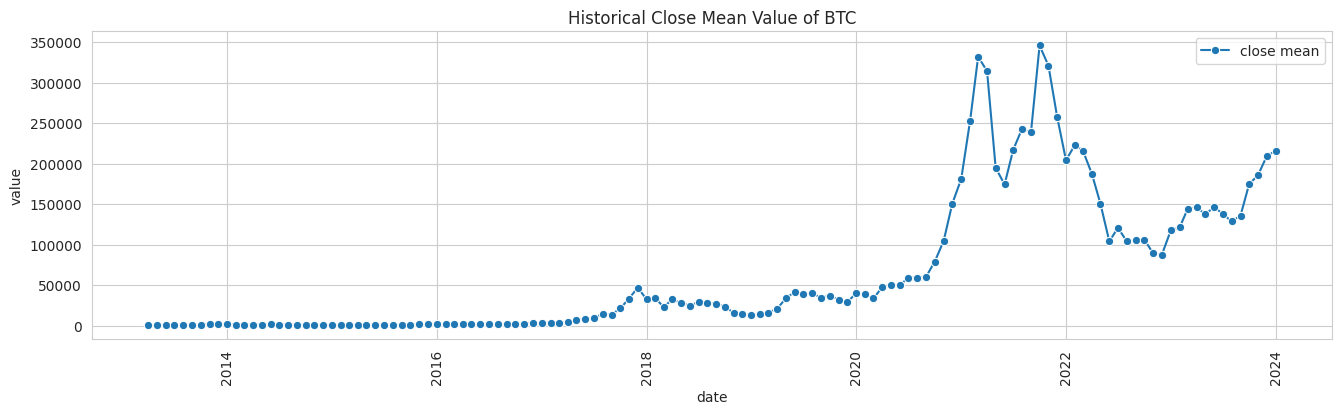

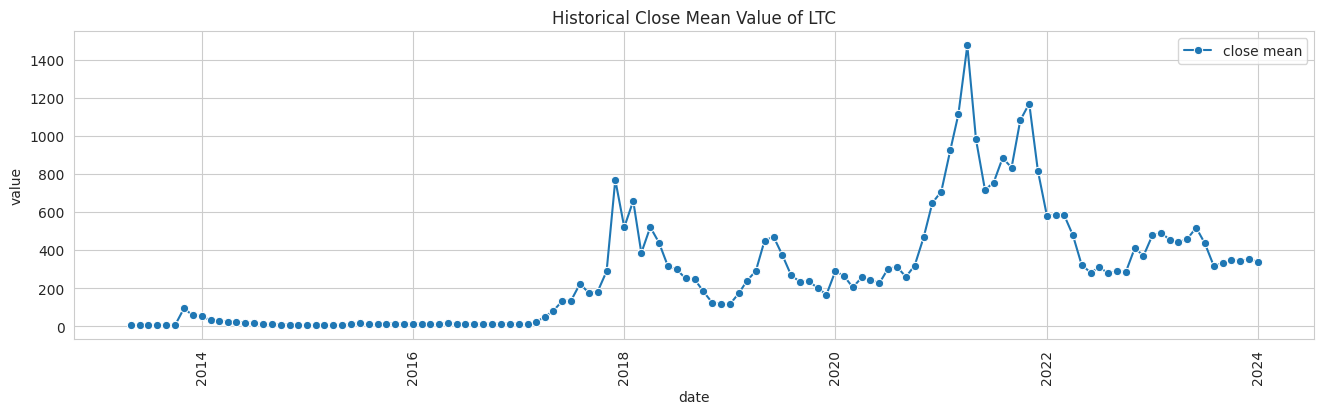

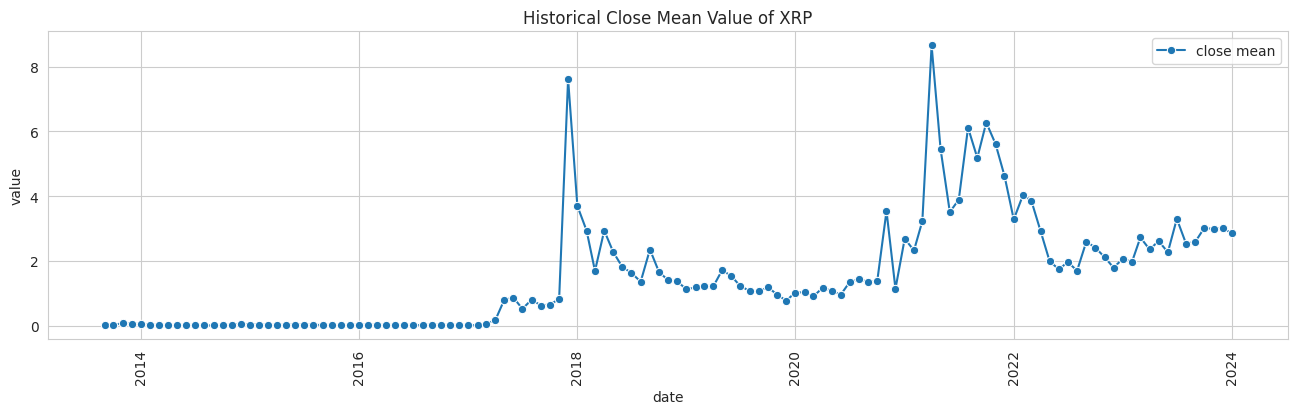

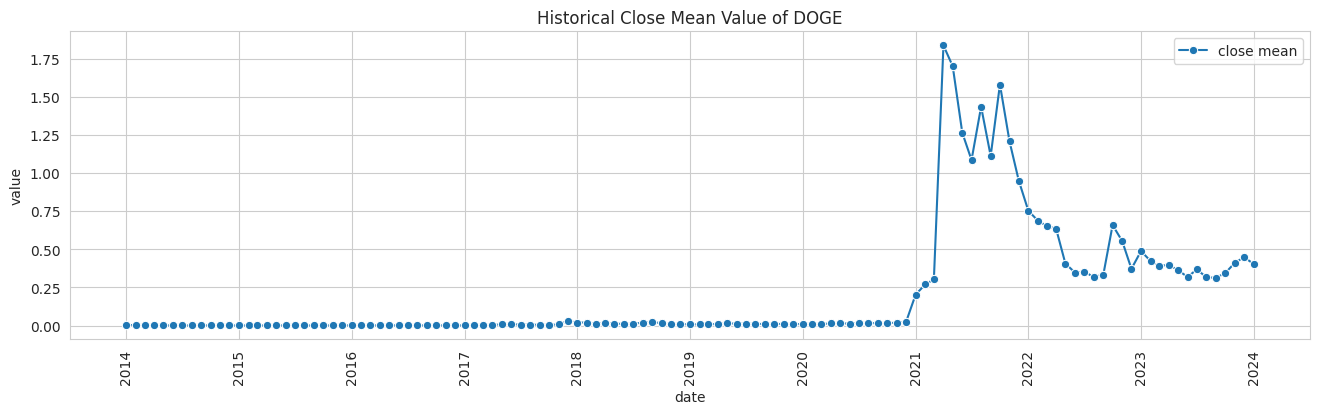

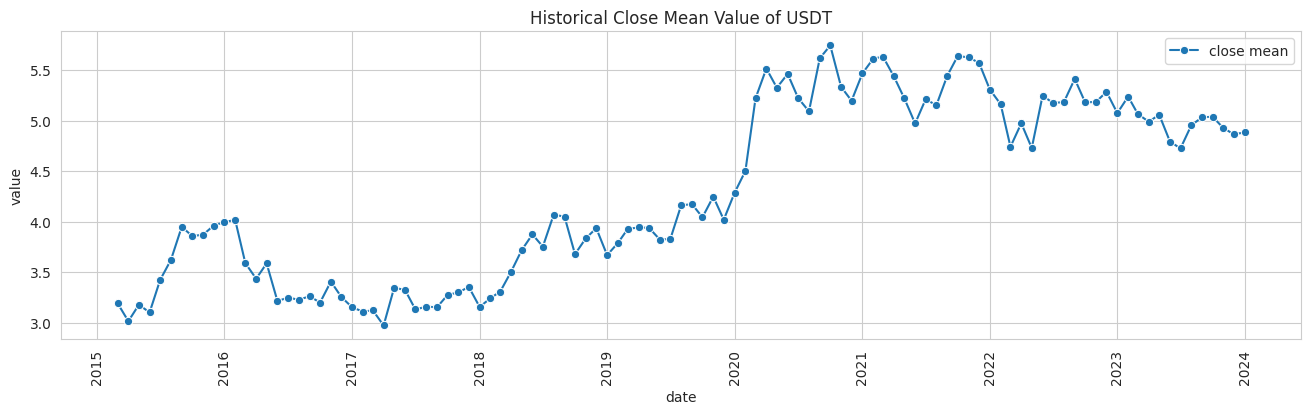

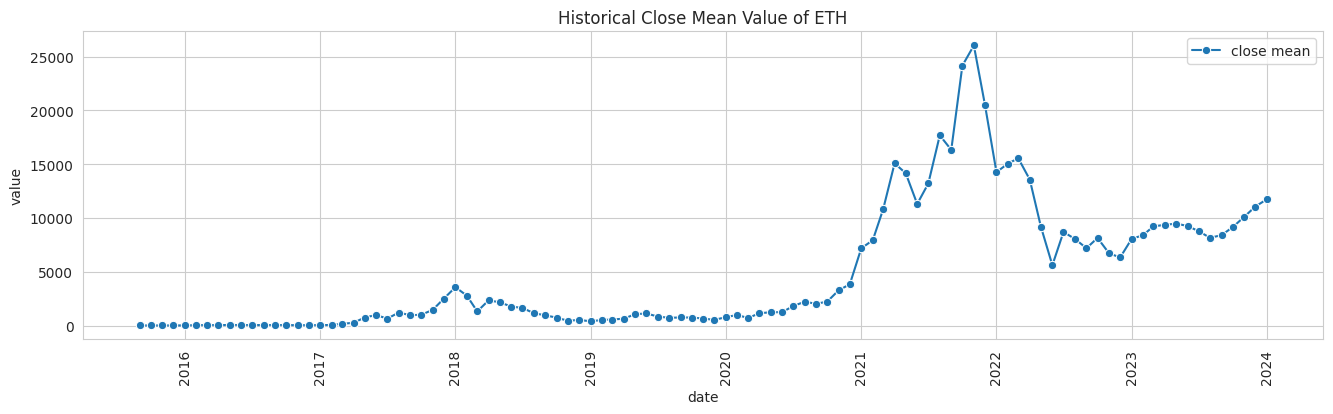

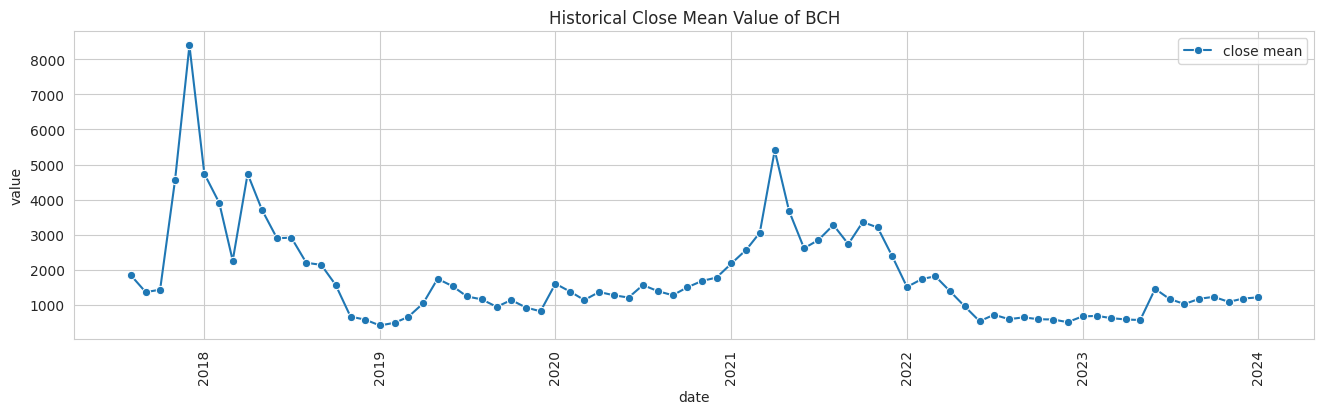

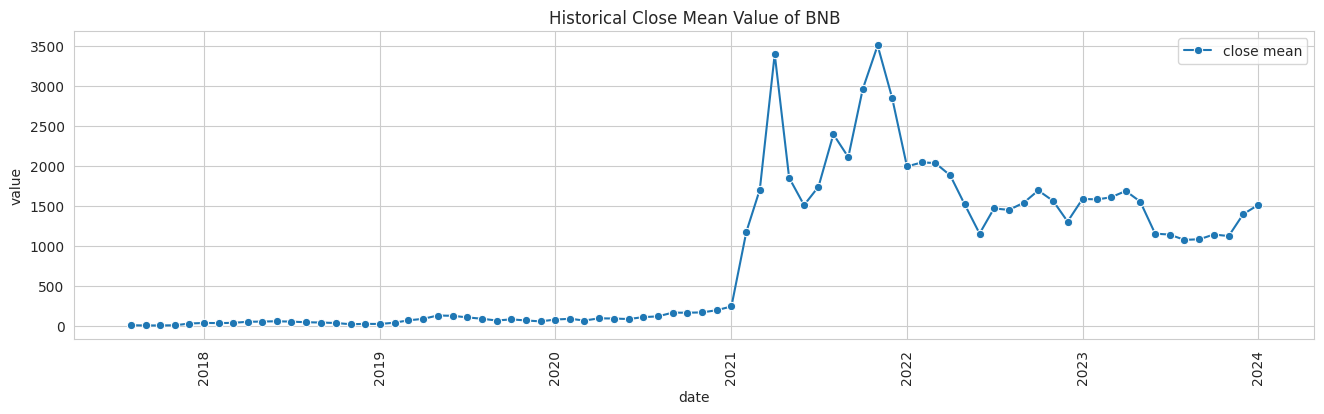

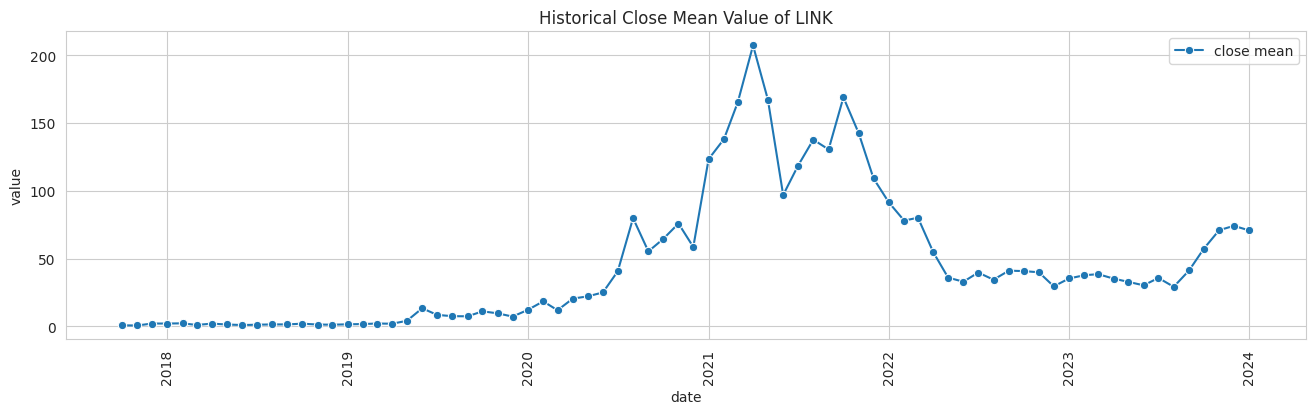

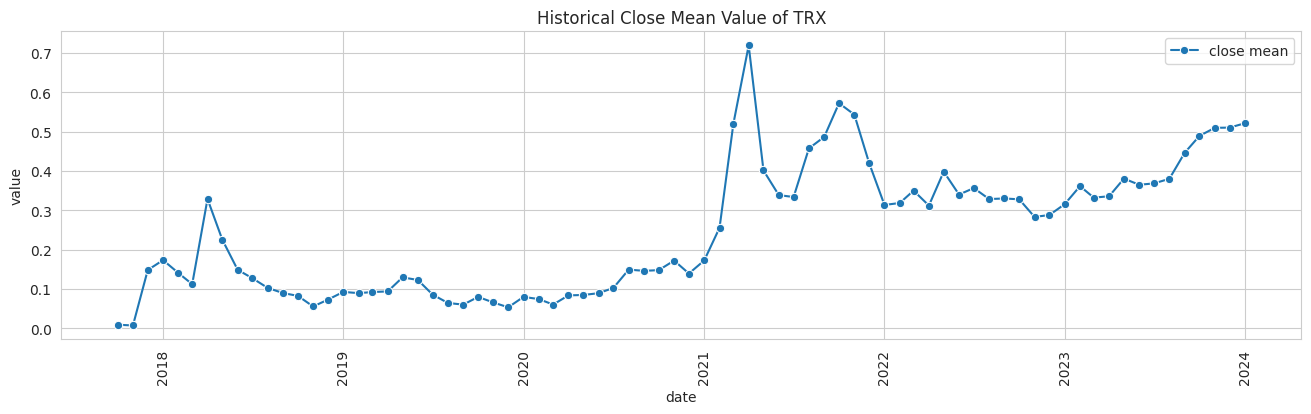

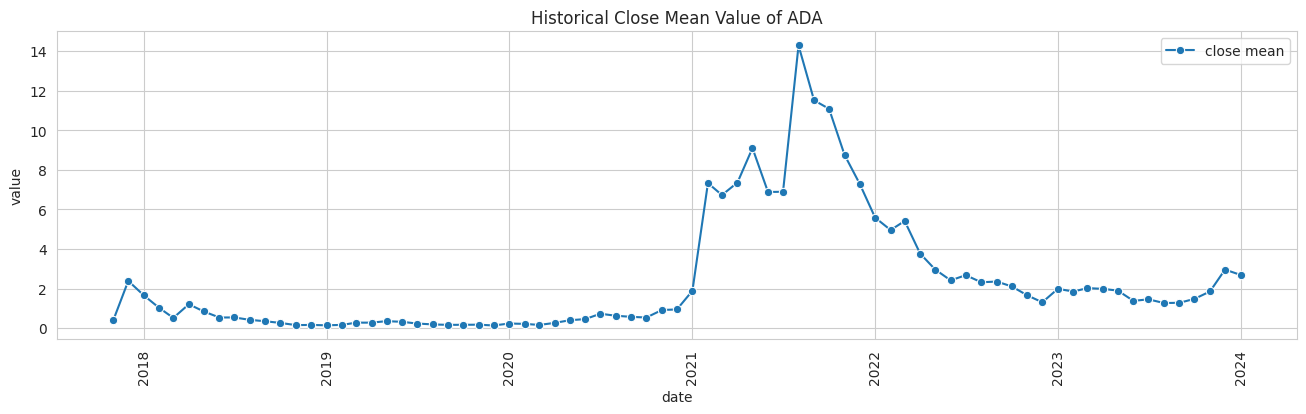

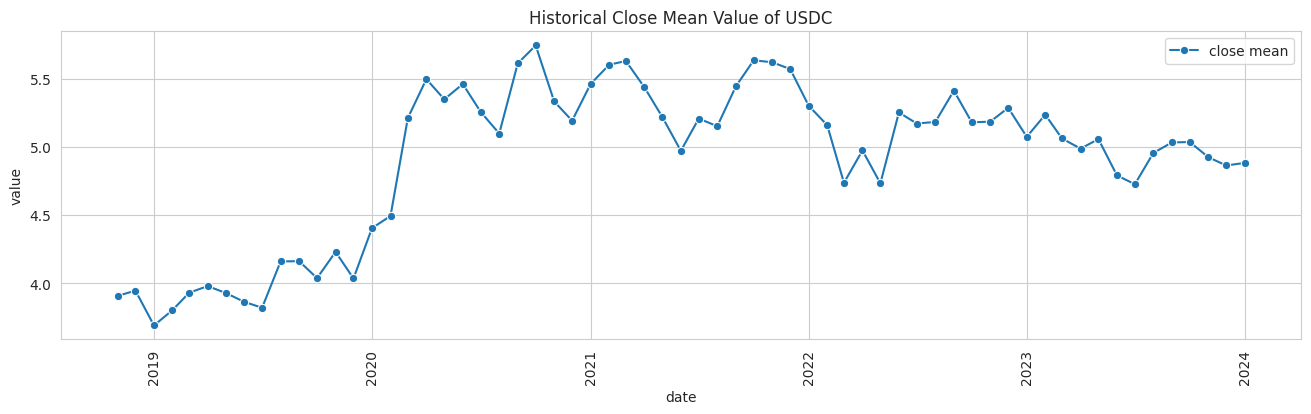

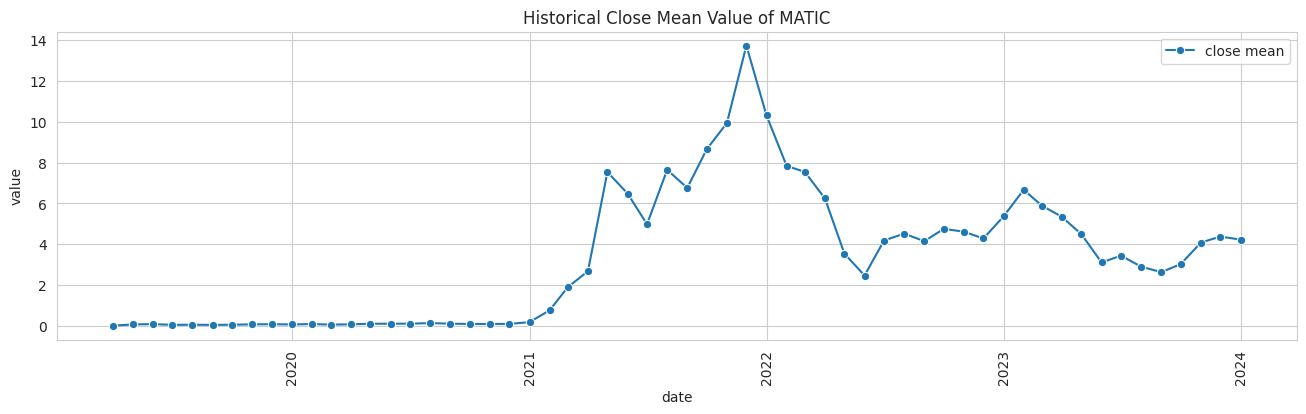

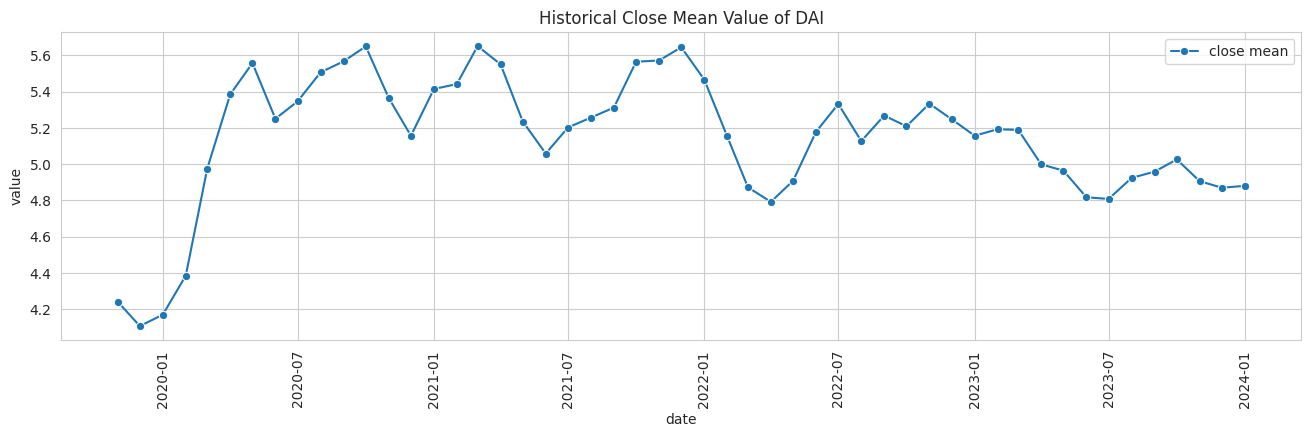

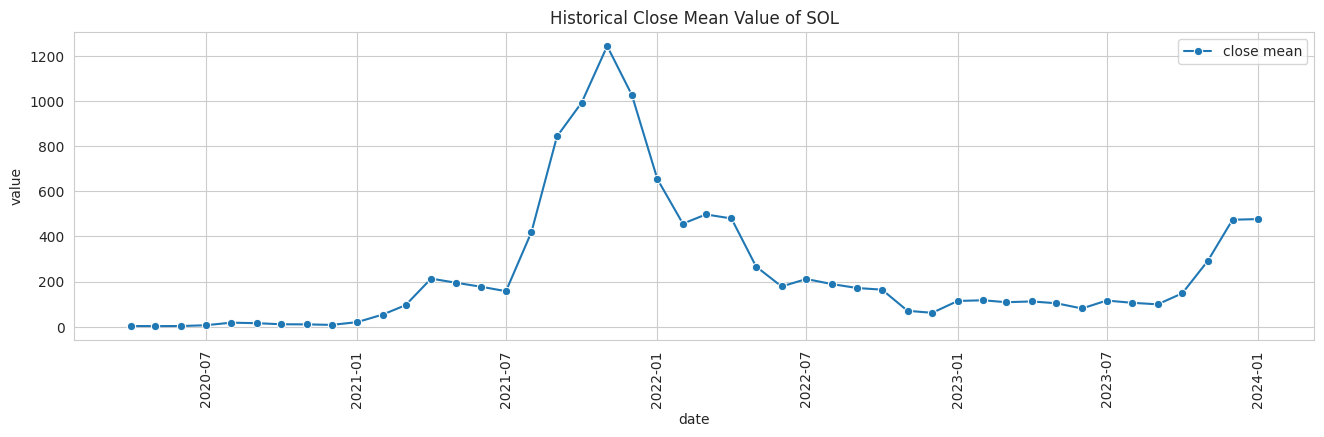

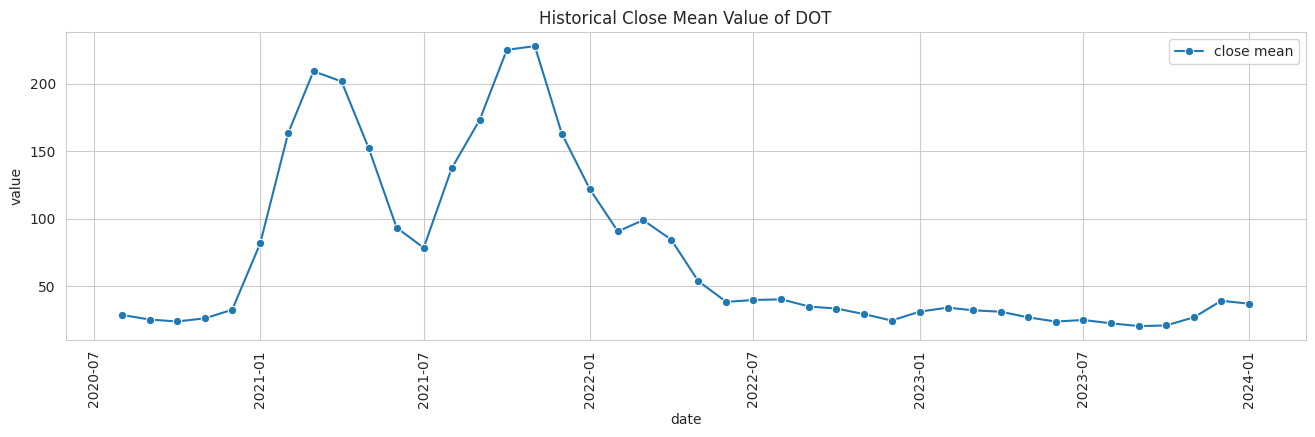

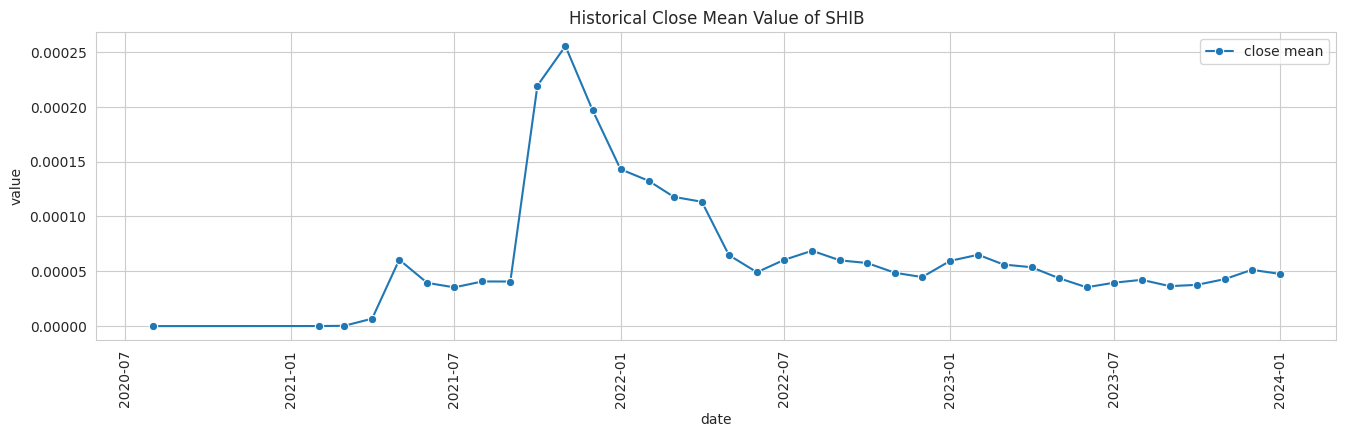

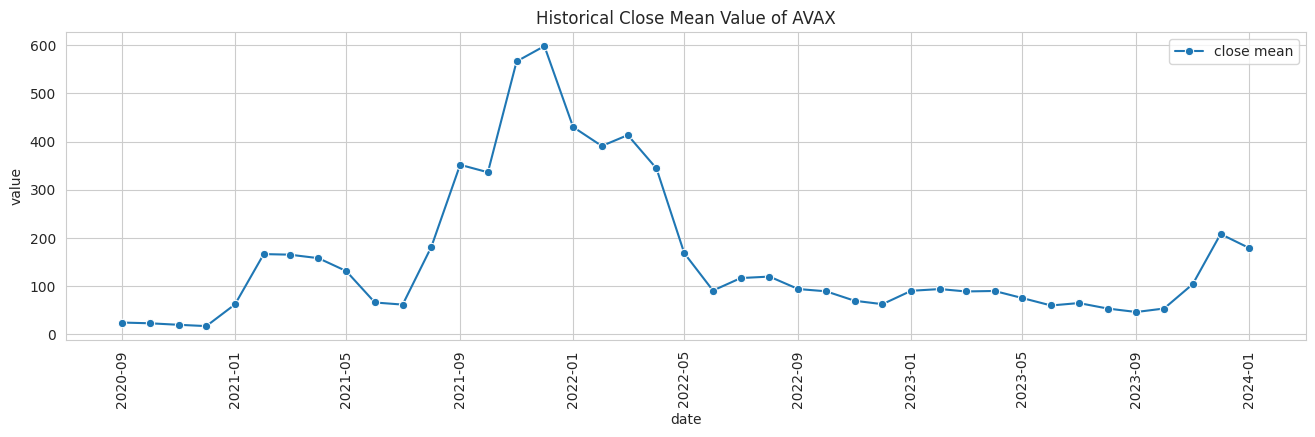

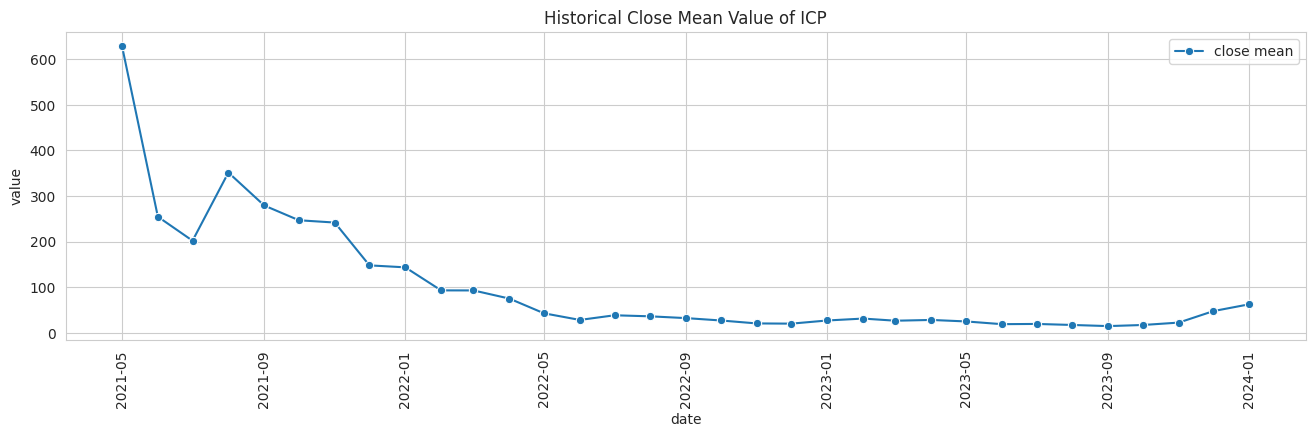

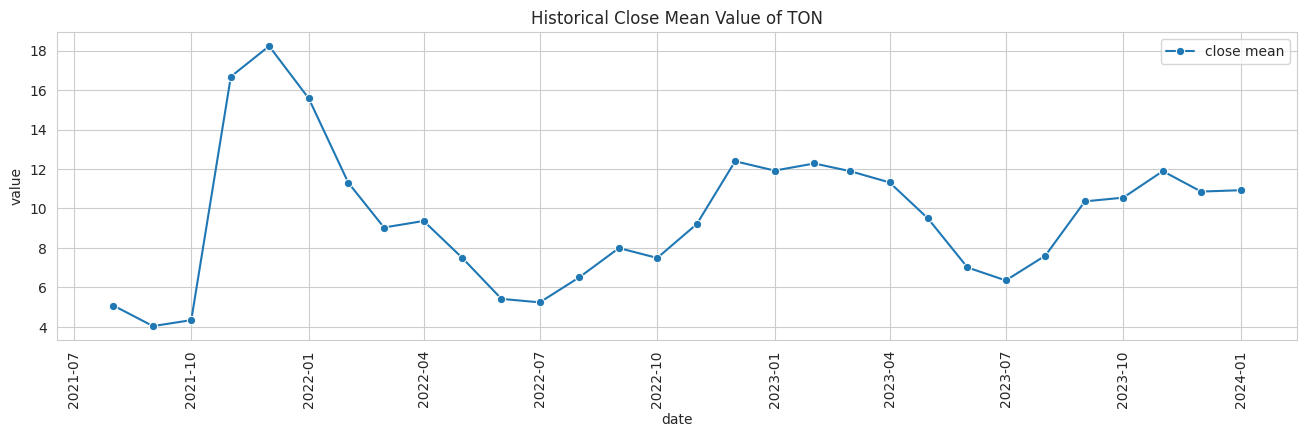

In [18]:
df_month_mean['close_mean_log'] = np.log(df_month_mean['close_mean'] + 1)  # Adicionando 1 para evitar log(0)

for tk in df_month_mean["ticker"].unique():
  db_temp = df_month_mean[df_month_mean["ticker"] == tk]

  # Plotando o histórico
  sns.lineplot(x='month', y='close_mean', data=db_temp, label='close mean', marker='o')

  # Configurando o título e os rótulos dos eixos
  plt.title(f'Historical Close Mean Value of {tk}')
  plt.xlabel('date')
  plt.ylabel('value')

  # Girando os rótulos dos meses em 90 graus
  plt.xticks(rotation=90)

  # Exibindo a legenda
  plt.legend()

  # Exibindo o gráfico
  plt.show()

In [19]:
# # pivotando para colunas para usar as demais como features
# df_month_mean_pivot = df_month_mean.pivot_table(index='month', columns='ticker', values='close_mean')
# df_month_mean_pivot.columns = df_month_mean_pivot.columns.astype(str) # tornando todos os nomes string
# df_month_mean_pivot = df_month_mean_pivot.fillna(0)
# df_month_mean_pivot.columns.name = None # removendo o nome da tabela que apareceria como colune
# df_month_mean_pivot = df_month_mean_pivot.reset_index()
# df_month_mean_pivot

def pivotar_dataframe(df):
    """
    Realiza a pivotagem de um DataFrame.

    Parameters:
    - df (pd.DataFrame): O DataFrame a ser pivotado.

    Returns:
    - df_pivotado (pd.DataFrame): O DataFrame resultante após a pivotagem.

    Example:
    >>> df = pd.DataFrame({'month': ['2022-01-01', '2022-02-01'],
    ...                    'ticker': ['AAPL', 'AAPL'],
    ...                    'close_mean': [105.0, 106.5]})
    >>> df_pivotado = pivotar_dataframe(df)
    >>> print(df_pivotado.head())
           month   AAPL
    0 2022-01-01  105.0
    1 2022-02-01  106.5
    """
    # Pivotar o DataFrame
    df_pivotado = df.pivot_table(index='month', columns='ticker', values='close_mean')

    # Tornar todos os nomes de coluna como string
    df_pivotado.columns = df_pivotado.columns.astype(str)

    # Preencher valores ausentes com 0
    df_pivotado = df_pivotado.fillna(0)

    # Resetar o índice e remover o nome da coluna
    df_pivotado = df_pivotado.reset_index()
    df_pivotado.columns.name = None

    return df_pivotado

# exemplo
df_month_mean_pivot = pivotar_dataframe(df_month_mean)
df_month_mean_pivot

,month,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
0,2013-04-01,0.000000,0.000000,0.000000,0.000000,278.528200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2013-05-01,0.000000,0.000000,0.000000,0.000000,276.292200,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.332617,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2013-06-01,0.000000,0.000000,0.000000,0.000000,215.594137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.651075,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,2013-07-01,0.000000,0.000000,0.000000,0.000000,241.503268,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.530263,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2013-08-01,0.000000,0.000000,0.000000,0.000000,322.417250,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.154942,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
125,2023-09-01,1.278491,46.015746,1179.371614,1081.088215,135716.038785,4.958072,0.312727,20.429899,8410.121815,15.201461,41.170842,332.495495,2.632787,0.000036,99.625336,10.357611,0.446303,5.033031,5.033556,2.593777
126,2023-10-01,1.476118,53.262540,1233.160901,1140.374171,174590.403638,5.025588,0.343852,20.903611,9147.868826,17.628649,57.285776,347.236878,3.028750,0.000038,148.516970,10.544974,0.489373,5.035799,5.037686,3.023081
127,2023-11-01,1.851059,103.991059,1091.157949,1121.206116,185712.655127,4.905604,0.410780,27.015103,10107.607140,22.868496,70.933182,341.977831,4.081885,0.000043,292.219539,11.889663,0.509749,4.924432,4.925170,2.985949
128,2023-12-01,2.956636,207.983406,1183.686354,1393.735938,208828.524615,4.869625,0.447636,39.187583,11061.517171,48.101172,74.160646,353.291442,4.374807,0.000051,474.193111,10.853732,0.510296,4.863749,4.864400,3.025213


## SALVANDO TABELAS

In [20]:
# SAVE SILVER
#silver_path = glob.glob('../silver/')
silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
silver_filename = "df_silver.parquet"
silver_save_path = silver_path + silver_filename

df.to_parquet(silver_save_path)
df_month_mean.to_parquet(silver_path + "df_month_mean.parquet")

# SAVE GOLD
#gold_path = glob.glob('../gold/')
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
gold_filename = "df_gold.parquet"
gold_save_path = gold_save_path + gold_filename

df_month_mean_pivot.to_parquet(gold_save_path)

In [21]:
import pandas as pd
import os

def salvar_dados(df, df_month_mean, df_month_mean_pivot, silver_path, gold_path):
    """
    Salva DataFrames em formatos específicos nos diretórios 'silver' e 'gold'.

    Parameters:
    - df (pd.DataFrame): O DataFrame principal a ser salvo em 'silver'.
    - df_month_mean (pd.DataFrame): O DataFrame a ser salvo em 'silver'.
    - df_month_mean_pivot (pd.DataFrame): O DataFrame a ser salvo em 'gold'.
    - silver_path (str): O caminho para o diretório 'silver'.
    - gold_path (str): O caminho para o diretório 'gold'.

    Returns:
    - None

    Example:
    >>> salvar_dados(df, df_month_mean, df_month_mean_pivot, "../crypto_forecast/silver/", "../crypto_forecast/gold/")
    """
    # Criar diretórios 'silver' e 'gold' se não existirem
    os.makedirs(silver_path, exist_ok=True)
    os.makedirs(gold_path, exist_ok=True)

    # Salvando no diretório 'silver'
    silver_filename = "df_silver.parquet"
    silver_save_path = os.path.join(silver_path, silver_filename)
    df.to_parquet(silver_save_path)

    df_month_mean_filename = "df_month_mean.parquet"
    df_month_mean_save_path = os.path.join(silver_path, df_month_mean_filename)
    df_month_mean.to_parquet(df_month_mean_save_path)

    # Salvando no diretório 'gold'
    gold_filename = "df_gold.parquet"
    gold_save_path = os.path.join(gold_path, gold_filename)
    df_month_mean_pivot.to_parquet(gold_save_path)

# exemplo
# silver_path = glob.glob('../silver/')
# gold_path = glob.glob('../gold/')

silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
gold_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"

salvar_dados(df, df_month_mean, df_month_mean_pivot, silver_path, gold_path)

# ANALYSIS

- [X] Previsão Univariada
- [X] Previsão Multivariada
- [X] Previsão com modelos de Bagging e Boosting
- [ ] Geração de dados sintéticos para previsão com bagging/boosting
- [ ] Automatização de tudo

In [22]:
stop

NameError: name 'stop' is not defined

## Previsão Univariada

In [ ]:
df = pd.read_parquet(gold_save_path)
df.set_index("month", inplace=True)
df.head()

In [ ]:
df.head()

In [ ]:
# import pandas as pd
# from statsmodels.tsa.stattools import adfuller

# def check_stationarity(df, alpha=0.05):
#     """
#     Verifica a estacionaridade de cada coluna em um DataFrame usando o teste Augmented Dickey-Fuller.

#     Parâmetros:
#     - df: DataFrame, o conjunto de dados
#     - alpha: float, nível de significância para o teste (padrão é 0.05)

#     Retorna:
#     - Lista de colunas que precisam de diferenciação de primeira ordem (não são estacionárias).
#     """
#     non_stationary_columns = []

#     for column in df.columns:
#         result = adfuller(df[column].values, autolag='AIC')
#         p_value = result[1]

#         if p_value > alpha:
#             non_stationary_columns.append(column)
#             print(f'A coluna {column} não é estacionária (p-value: {p_value})')

#     return non_stationary_columns

# # Utilize a função no seu conjunto de dados
# non_stationary_cols = check_stationarity(df)
# non_stationary_cols

import pandas as pd
from statsmodels.tsa.stattools import adfuller

def check_and_difference(df, alpha=0.05, max_diff=5):
    """
    Verifica a estacionaridade de cada coluna em um DataFrame usando o teste Augmented Dickey-Fuller.
    Realiza diferenciação até que a série seja estacionária.

    Parâmetros:
    - df: DataFrame, o conjunto de dados
    - alpha: float, nível de significância para o teste (padrão é 0.05)
    - max_diff: int, número máximo de diferenciações a serem realizadas (padrão é 5)

    Retorna:
    - Dictionary contendo o número de diferenciações necessárias para cada coluna.
    """
    diff_counts = {}

    for column in df.columns:
        series = df[column]
        is_stationary = False
        diff_count = 0

        while not is_stationary and diff_count < max_diff:
            result = adfuller(series, autolag='AIC')
            p_value = result[1]

            if p_value > alpha:
                # Ainda não é estacionária, realiza mais uma diferenciação
                series = series.diff().dropna()
                diff_count += 1
            else:
                is_stationary = True

        diff_counts[column] = diff_count

        if diff_count > 0:
            print(f'A coluna {column} tornou-se estacionária após {diff_count} diferenciações.')

    return diff_counts

# Utilize a função no seu conjunto de dados
diff_counts = check_and_difference(df)
diff_counts

In [ ]:
target = "BTC"
# target = "ICP"

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

# preparar os dados
# target = "ETH"
df_uni = df[df[target] > 0][[target]].copy()

# # Dividir os dados em treinamento e teste
# train_size = int(len(df_uni) * 0.95)
# train, test = df_uni[:train_size], df_uni[train_size:]

# Dividir os dados em treinamento e teste
train_size = len(df_uni) - 8 # ultimos 6 pontos
train, test = df_uni[:train_size], df_uni[train_size:]

arima_params = {'seasonal': True, 'm': 12, 'd': 1, 'D': 1, 'max_P': 3, 'max_Q': 3,
    		'information_criterion': 'aic', 'trace': False, 'error_action': 'ignore',
    		'stepwise': True}

# Ajustar o modelo AutoARIMA aos dados de treinamento
model = auto_arima(train[target].values, **arima_params)
model.fit(train[target].values)

# Fazer previsões in-sample para o conjunto de teste
forecast_in_sample, conf_int_in_sample = model.predict(n_periods=len(test), return_conf_int=True)

# Estender o índice do DataFrame de previsão in-sample para incluir datas futuras
forecast_index_in_sample = pd.date_range(start=test.index[0], periods=len(test), freq='m').to_period('M').to_timestamp()
forecast_df_in_sample = pd.DataFrame(forecast_in_sample, columns=['predicted_in_sample'], index=forecast_index_in_sample)

# Fazer previsões out-of-sample
n_periods_out_of_sample = 6  # ou qualquer valor desejado
forecast_out_of_sample, conf_int_out_of_sample = model.predict(n_periods=n_periods_out_of_sample, return_conf_int=True)

# Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
forecast_index_out_of_sample = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
forecast_df_out_of_sample = pd.DataFrame(forecast_out_of_sample, columns=['predicted_out_of_sample'], index=forecast_index_out_of_sample)

# Plotar os resultados
plt.figure(figsize=(14, 8))
plt.plot(train, label='Treinamento')
plt.plot(test, label='Teste')
plt.plot(forecast_df_in_sample, label='Previsão In Sample', linestyle='dashed')
plt.plot(forecast_df_out_of_sample, label='Previsão Out of Sample', linestyle='dashed', color='orange')
plt.fill_between(forecast_index_in_sample, conf_int_in_sample[:, 0], conf_int_in_sample[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança In Sample')
plt.fill_between(forecast_index_out_of_sample, conf_int_out_of_sample[:, 0], conf_int_out_of_sample[:, 1], color='orange', alpha=0.2, label='Intervalo de Confiança Out of Sample')
plt.legend()
plt.title(f'AutoARIMA Forecast Example para {target}')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [ ]:
model.get_params()

In [ ]:
test

In [ ]:
# Calcular o MAPE
actual_values = test[target].values
predicted_values_in_sample = forecast_df_in_sample['predicted_in_sample'].values
mape_in_sample_sarima = np.mean(np.abs((actual_values - predicted_values_in_sample) / actual_values)) * 100
print(f"MAPE In Sample: {mape_in_sample_sarima:.2f}%")

In [ ]:
df.isna().sum()

In [ ]:
# df_metrics = {}

# for ticker in tqdm(df.columns):
#   # sampling target
#   df_uni = df.fillna(0).copy()
#   df_uni = df_uni[df_uni[ticker] > 0][[target]].copy()

#   # Dividir os dados em treinamento e teste
#   train_size = len(df_uni) - 8 # ultimos 6 pontos
#   train, test = df_uni[:train_size], df_uni[train_size:]

#   # Ajustar o modelo AutoARIMA aos dados de treinamento
#   model = auto_arima(train[target].values,
#                     seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
#                     information_criterion='aic',
#                     trace=False, error_action='ignore', stepwise=True)
#   model.fit(train[target].values, )

#   # Fazer previsões in-sample para o conjunto de teste
#   forecast_in_sample, conf_int_in_sample = model.predict(n_periods=len(test), return_conf_int=True)

#   # Estender o índice do DataFrame de previsão in-sample para incluir datas futuras
#   forecast_index_in_sample = pd.date_range(start=test.index[0], periods=len(test), freq='m').to_period('M').to_timestamp()
#   forecast_df_in_sample = pd.DataFrame(forecast_in_sample, columns=['predicted_in_sample'], index=forecast_index_in_sample)

#   # calculando MAPE
#   actual_values = test[target].values
#   predicted_values_in_sample = forecast_df_in_sample['predicted_in_sample'].values
#   mape_in_sample_sarima = np.mean(np.abs((actual_values - predicted_values_in_sample) / actual_values)) * 100

#   df_metrics["ticker"] = ticker
#   df_metrics["best_order"] = model.order
#   df_metrics["seasonal_order"] = model.seasonal_order
#   df_metrics["mape"] = mape_in_sample_sarima

In [ ]:
stop

## Previsão Multivariada

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
from pmdarima.model_selection import train_test_split

# target = "ETH"

#exogenous_vars = [col for col in df.columns if col != target]
thresh = 0.8
correlations = df.corrwith(df[target], method="pearson")
exogenous_vars = correlations[(correlations.abs() > thresh)].index
exogenous_vars = exogenous_vars.to_list()
exogenous_vars = [column for column in exogenous_vars if column != target]
exogenous_vars

# # Dividir os dados em treinamento e teste
# train_size = int(len(df) * 0.95)
# train, test = df[:train_size], df[train_size:]

# Dividir os dados em treinamento e teste
train_size = len(df) - 8 # ultimos 6 pontos
train, test = df[:train_size], df[train_size:]

# Ajustar o modelo AutoARIMA aos dados de treinamento
model = auto_arima(train[target].values,
                   exogenous=train[exogenous_vars],
                   seasonal=True, m=12, D=1, start_P=1, start_Q=1, max_P=3, max_Q=3,
                   information_criterion='aic',
                   trace=True, error_action='ignore', stepwise=True)
model.fit(train[target].values)

# Fazer previsões in-sample para o conjunto de teste
forecast_in_sample, conf_int_in_sample = model.predict(n_periods=len(test),
                                                       exogenous=test[exogenous_vars].values,
                                                       return_conf_int=True)

# Estender o índice do DataFrame de previsão in-sample para incluir datas futuras
forecast_index_in_sample = pd.date_range(start=test.index[0], periods=len(test), freq='m').to_period('M').to_timestamp()
forecast_df_in_sample = pd.DataFrame(forecast_in_sample, columns=['predicted_in_sample'], index=forecast_index_in_sample)

# Fazer previsões out-of-sample
n_periods_out_of_sample = 6  # ou qualquer valor desejado
forecast_out_of_sample, conf_int_out_of_sample = model.predict(n_periods=n_periods_out_of_sample,
                                                               exogenous=test.iloc[-1][exogenous_vars].values.reshape(1, -1),
                                                               return_conf_int=True)

# Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
forecast_index_out_of_sample = pd.date_range(start=test.index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
forecast_df_out_of_sample = pd.DataFrame(forecast_out_of_sample, columns=['predicted_out_of_sample'], index=forecast_index_out_of_sample)

# Plotar os resultados
plt.figure(figsize=(14, 8))
plt.plot(train[target], label='Treinamento')
plt.plot(test[target], label='Teste')
plt.plot(forecast_df_in_sample, label='Previsão In Sample', linestyle='dashed')
plt.plot(forecast_df_out_of_sample, label='Previsão Out of Sample', linestyle='dashed', color='orange')
plt.fill_between(forecast_index_in_sample, conf_int_in_sample[:, 0], conf_int_in_sample[:, 1], color='gray', alpha=0.2, label='Intervalo de Confiança In Sample')
plt.fill_between(forecast_index_out_of_sample, conf_int_out_of_sample[:, 0], conf_int_out_of_sample[:, 1], color='orange', alpha=0.2, label='Intervalo de Confiança Out of Sample')
plt.legend()
plt.title(f'AutoARIMA Forecast Example para {target}')
plt.xlabel('Data')
plt.ylabel('Valor')
plt.show()

In [ ]:
# Calcular o MAPE
actual_values = test[target].values
predicted_values_in_sample = forecast_df_in_sample['predicted_in_sample'].values
mape_in_sample_sarimax = np.mean(np.abs((actual_values - predicted_values_in_sample) / actual_values)) * 100
print(f"MAPE In Sample: {mape_in_sample_sarimax:.2f}%")

## Bagging e Boosting

In [ ]:
random_state = 42
random_forest_model = RandomForestRegressor(n_estimators=100, random_state=random_state)
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=random_state)

In [ ]:
#target = "ETH"
thresh = 0.9

correlations = df.corrwith(df[target], method="pearson")
high_correlation_columns = correlations[(correlations.abs() > thresh)].index
high_correlation_columns = high_correlation_columns.to_list()
high_correlation_columns = [column for column in high_correlation_columns if column != target]
high_correlation_columns

In [ ]:
from sklearn.metrics import mean_absolute_error

df_test = df.reset_index()
df_test

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, test_size=2)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data[f"{target}"]
    X_test, y_test = test_data[high_correlation_columns], test_data[f"{target}"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()
    rf_column_name = f'{target}_RF'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()
    xgb_column_name = f'{target}_XGB'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

In [ ]:
df_test

In [ ]:
# Calcular o MAPE
df_test_mm = df_test[[f"{target}", f"{target}_RF", f"{target}_XGB"]].dropna()

actual_values = df_test_mm[target].values
predicted_values_in_sample_rf = df_test_mm[ f"{target}_RF"].values
predicted_values_in_sample_xgb = df_test_mm[ f"{target}_XGB"].values

mape_in_sample_rf = np.mean(np.abs((actual_values - predicted_values_in_sample_rf) / actual_values)) * 100
mape_in_sample_xgb = np.mean(np.abs((actual_values - predicted_values_in_sample_xgb) / actual_values)) * 100

print(f"Target: {target}")
print(f"MAPE In Sample ARIMA: {mape_in_sample_sarima:.2f}%")
print(f"MAPE In Sample SARIMAX: {mape_in_sample_sarimax:.2f}%")
print(f"MAPE In Sample RF: {mape_in_sample_rf:.2f}%")
print(f"MAPE In Sample XGB: {mape_in_sample_xgb:.2f}%")

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd

df_test = df.reset_index()

# Criando o objeto TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=4, test_size=2)  # 5 * 3 = 15 predicoes in sample
random_state = 42

# Inicializando listas para armazenar métricas
metrics_rf_train = []
metrics_rf_test = []
metrics_xgb_train = []
metrics_xgb_test = []

# Loop pelos splits do TimeSeriesSplit
for train_index, test_index in tscv.split(df_test):
    # Dividindo os dados em conjuntos de treinamento e teste
    train_data, test_data = df_test.iloc[train_index], df_test.iloc[test_index]

    # Separando as features e o alvo para treinamento e teste
    X_train, y_train = train_data[high_correlation_columns], train_data[f"{target}"]
    X_test, y_test = test_data[high_correlation_columns], test_data[f"{target}"]

    # Treinando e fazendo previsões com o modelo Random Forest
    random_forest_model.fit(X_train.values, y_train)
    rf_predictions = random_forest_model.predict(X_test).ravel()
    rf_column_name = f'{target}_RF'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, rf_column_name] = rf_predictions[:len(test_index)]

    # MÉTRICAS
    # Métricas no conjunto de treinamento
    train_rmse_rf = mean_squared_error(y_train, random_forest_model.predict(X_train), squared=False)
    train_mape_rf = mean_absolute_error(y_train, random_forest_model.predict(X_train)) / y_train.mean() * 100
    metrics_rf_train.append({'Train_RMSE': train_rmse_rf, 'Train_MAPE': train_mape_rf})

    # Métricas no conjunto de teste
    test_rmse_rf = mean_squared_error(y_test, rf_predictions, squared=False)
    test_mape_rf = mean_absolute_error(y_test, rf_predictions) / y_test.mean() * 100
    metrics_rf_test.append({'Test_RMSE': test_rmse_rf, 'Test_MAPE': test_mape_rf})

    # Treinando e fazendo previsões com o modelo XGBoost
    xgboost_model.fit(X_train.values, y_train)
    xgb_predictions = xgboost_model.predict(X_test).ravel()
    xgb_column_name = f'{target}_XGB'

    # Adicionando as previsões nos índices correspondentes
    df_test.loc[test_index, xgb_column_name] = xgb_predictions[:len(test_index)]

    # Métricas no conjunto de treinamento
    train_rmse_xgb = mean_squared_error(y_train, xgboost_model.predict(X_train), squared=False)
    train_mape_xgb = mean_absolute_error(y_train, xgboost_model.predict(X_train)) / y_train.mean() * 100
    metrics_xgb_train.append({'Train_RMSE': train_rmse_xgb, 'Train_MAPE': train_mape_xgb})

    # Métricas no conjunto de teste
    test_rmse_xgb = mean_squared_error(y_test, xgb_predictions, squared=False)
    test_mape_xgb = mean_absolute_error(y_test, xgb_predictions) / y_test.mean() * 100
    metrics_xgb_test.append({'Test_RMSE': test_rmse_xgb, 'Test_MAPE': test_mape_xgb})

# Criando DataFrames com as métricas
df_metrics_rf_train = pd.DataFrame(metrics_rf_train)
df_metrics_rf_train['Model'] = 'RandomForest'

df_metrics_rf_test = pd.DataFrame(metrics_rf_test)
df_metrics_rf_test['Model'] = 'RandomForest'

df_metrics_xgb_train = pd.DataFrame(metrics_xgb_train)
df_metrics_xgb_train['Model'] = 'XGBoost'

df_metrics_xgb_test = pd.DataFrame(metrics_xgb_test)
df_metrics_xgb_test['Model'] = 'XGBoost'

# Juntando os DataFrames em um único DataFrame
metrics_rf =  pd.concat([df_metrics_rf_train, df_metrics_rf_test], axis=1)
metrics_xgb =  pd.concat([df_metrics_xgb_train, df_metrics_xgb_test], axis=1)

df_all_metrics = pd.concat([metrics_rf, metrics_xgb],  axis=0) #, ignore_index=True)
df_all_metrics[["Model", "Train_RMSE", "Test_RMSE", "Train_MAPE", "Test_MAPE"]]

# OUT OF SAMPLE FORECAST

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [63]:
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
gold_filename = "df_gold.parquet"
gold_file_path = gold_save_path + gold_filename

df = pd.read_parquet(gold_file_path)
df.set_index("month", inplace=True)
df.head()

,ADA,AVAX,BCH,BNB,BTC,DAI,DOGE,DOT,ETH,ICP,LINK,LTC,MATIC,SHIB,SOL,TON,TRX,USDC,USDT,XRP
month,,,,,,,,,,,,,,,,,,,,
2013-04-01,0.0,0.0,0.0,0.0,278.528200,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-01,0.0,0.0,0.0,0.0,276.292200,0.0,0.0,0.0,0.0,0.0,0.0,6.332617,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-06-01,0.0,0.0,0.0,0.0,215.594137,0.0,0.0,0.0,0.0,0.0,0.0,6.651075,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-07-01,0.0,0.0,0.0,0.0,241.503268,0.0,0.0,0.0,0.0,0.0,0.0,6.530263,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-08-01,0.0,0.0,0.0,0.0,322.417250,0.0,0.0,0.0,0.0,0.0,0.0,6.154942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
silver_path = glob.glob('../silver/')
silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"

df_forecast = pd.read_parquet(silver_path + "df_month_mean.parquet")
df_forecast.set_index("month", inplace=True)
df_forecast["type"] = "HIST"
df_forecast["model"] = "HIST"
df_forecast = df_forecast[["ticker", "close_mean", "type", "model"]].copy()
df_forecast

In [ ]:
# CONFIG
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
filename = "best_params_dict.json"
gold_save_path = gold_save_path + filename
best_params_dict = {}

arima_params = {'seasonal': True, 'm': 12, 'd': 1, 'D': 1, 'max_P': 3, 'max_Q': 3,
    		'information_criterion': 'aic', 'trace': False, 'error_action': 'ignore',
    		'stepwise': True}

import os

def processar_e_salvar_params(gold_save_path, filename, df, build_best_params=False):
    """
    Processa os parâmetros para cada ticker no DataFrame df usando auto_arima e salva os resultados em um arquivo JSON.

    Parameters:
    - gold_save_path (str): Caminho onde o arquivo será salvo.
    - filename (str): Nome do arquivo a ser salvo.
    - df (pandas.DataFrame): DataFrame contendo os dados para os quais os parâmetros serão calculados.
    - build_best_params (bool, optional): Indica se deve criar um novo arquivo de parâmetros ou apenas verificar se o arquivo já existe.
                                          Se True, cria um novo arquivo; se False (padrão), verifica a existência do arquivo.

    Returns:
    None

    Example:
    processar_e_salvar_params(gold_save_path, "best_params_dict.json", df, build_best_params=False)
    """

    # Verificando se o arquivo já existe
    if os.path.exists(gold_save_path) and not build_best_params:
        print(f'O conjunto de parâmetros para cada ticker {filename} já existe. Não foi criado um novo arquivo.')
    else:
        best_params_dict = {}
        # for tk in tqdm(df.columns, desc=f"Processando parâmetros para {tk}"):
        for tk in tqdm(df.columns):
            model = auto_arima(df[tk].values, **arima_params)
            best_order = model.order
            best_seasonal_order = model.seasonal_order
            best_params_dict[tk] = {"best_order": model.order, "best_seasonal_order": model.seasonal_order}

        # Salvando o dicionário usando json
        with open(gold_save_path, 'w') as arquivo:
            json.dump(best_params_dict, arquivo)
        print(f'Dicionário salvo em {gold_save_path}')

# Exemplo de chamada da função
processar_e_salvar_params(gold_save_path, "best_params_dict.json", df, build_best_params=True)

In [59]:
import json

def carregar_dicionario_params(caminho_arquivo):
    """
    Carrega um dicionário a partir de um arquivo JSON.

    Parameters:
    - caminho_arquivo (str): O caminho para o arquivo JSON a ser carregado.

    Returns:
    - dict: O dicionário carregado a partir do arquivo JSON.

    Example:
    >>> best_params_dict = carregar_dicionario("../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/df_gold.parquet")
    >>> print(best_params_dict)
    {'BTC': {'best_order': (1, 1, 1), 'best_seasonal_order': (0, 1, 1, 12)}, ...}
    """
    with open(caminho_arquivo, 'r') as arquivo:
        dicionario_carregado = json.load(arquivo)

    return dicionario_carregado

# exemplo
gold_save_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"
filename = "best_params_dict.json"
gold_save_path = gold_save_path + filename
best_params_dict = {}
best_params_dict = carregar_dicionario_params(gold_save_path)
best_params_dict

{'ADA': {'best_order': [0, 1, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'AVAX': {'best_order': [1, 1, 1], 'best_seasonal_order': [0, 1, 2, 12]},
 'BCH': {'best_order': [0, 1, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'BNB': {'best_order': [0, 1, 0], 'best_seasonal_order': [0, 1, 1, 12]},
 'BTC': {'best_order': [0, 1, 1], 'best_seasonal_order': [0, 1, 2, 12]},
 'DAI': {'best_order': [0, 1, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'DOGE': {'best_order': [0, 1, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'DOT': {'best_order': [5, 1, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'ETH': {'best_order': [2, 1, 2], 'best_seasonal_order': [1, 1, 1, 12]},
 'ICP': {'best_order': [2, 1, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'LINK': {'best_order': [1, 1, 1], 'best_seasonal_order': [3, 1, 0, 12]},
 'LTC': {'best_order': [0, 1, 0], 'best_seasonal_order': [3, 1, 0, 12]},
 'MATIC': {'best_order': [0, 1, 0], 'best_seasonal_order': [2, 1, 1, 12]},
 'SHIB': {'best_order': [2, 1, 1], 'best_seaso

In [ ]:
# BEST_ORDER = best_params_dict["BTC"]["best_order"]
# BEST_SEASONAL_ORDER = best_params_dict["BTC"]["best_seasonal_order"]
# BEST_ORDER, BEST_SEASONAL_ORDER

In [ ]:
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# target = "BTC"
# BEST_ORDER = best_params_dict["BTC"]["best_order"]
# BEST_SEASONAL_ORDER = best_params_dict["BTC"]["best_seasonal_order"]
# n_periods_out_of_sample = 6

# model = SARIMAX(df['BTC'], order=BEST_ORDER,  seasonal_order=BEST_SEASONAL_ORDER)
# res = model.fit()

# n_periods_out_of_sample = 6  # ou qualquer valor desejado
# # forecast_out_of_sample = res.predict(n_periods=n_periods_out_of_sample, steps=n_periods_out_of_sample)
# fs = res.get_forecast(steps=n_periods_out_of_sample)
# fs_values = fs.predicted_mean
# fs_lower_bound = fs.conf_int().iloc[:,0]
# fs_upper_bound = fs.conf_int().iloc[:,1]

# fs_values_df = fs_values.reset_index()
# fs_values_df["lower_bound"] = fs_lower_bound.values
# fs_values_df["upper_bound"] = fs_upper_bound.values

# # Estender o índice do DataFrame de previsão out-of-sample para incluir datas futuras
# forecast_index_out_of_sample = pd.date_range(start=df['BTC'].index[-1] + pd.DateOffset(1), periods=n_periods_out_of_sample, freq='m').to_period('M').to_timestamp()
# fs_df = pd.DataFrame(fs_values.values, columns=[f'close_mean'], index=fs_values.index)
# fs_df["lower_bound"] = fs_lower_bound.values
# fs_df["upper_bound"] = fs_upper_bound.values
# fs_df["ticker"] = target
# fs_df["type"] = "PRED"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def gerar_previsoes_sarimax(df, best_params_dict, n_periods_out_of_sample=6):
    """
    Gera previsões utilizando o modelo SARIMAX para várias séries temporais.

    Parameters:
    - df (pd.DataFrame): O DataFrame contendo as séries temporais.
    - best_params_dict (dict): Um dicionário contendo os melhores parâmetros para cada série.
    - n_periods_out_of_sample (int): O número de períodos para prever out-of-sample.

    Returns:
    - fs_df (pd.DataFrame): Um DataFrame contendo as previsões, intervalos de confiança e informações adicionais.

    Example:
    >>> df = ...  # Seu DataFrame com séries temporais
    >>> best_params_dict = {'BTC': {'best_order': (1, 1, 1), 'best_seasonal_order': (0, 1, 1, 12)}}
    >>> fs_df = gerar_previsoes_sarimax(df, best_params_dict, n_periods_out_of_sample=6)
    >>> print(fs_df.head())
             close_mean  lower_bound  upper_bound ticker  type
    2023-01-01    ...         ...         ...       BTC  PRED
    ...           ...         ...         ...       ...  ...
    """
    fs_df = pd.DataFrame()

    print("Gerando Previsões SARIMAX")
    for tk, params in tqdm(best_params_dict.items()):

        #print(f" Prevendo valores para {tk}")
        BEST_ORDER = params["best_order"]
        BEST_SEASONAL_ORDER = params["best_seasonal_order"]

        model = SARIMAX(df[f'{tk}'], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER, freq="MS")
        res = model.fit()

        fs = res.get_forecast(steps=n_periods_out_of_sample)
        fs_values = fs.predicted_mean
        fs_lower_bound = fs.conf_int().iloc[:, 0]
        fs_upper_bound = fs.conf_int().iloc[:, 1]

        #  fs_values_df = pd.DataFrame(fs_values.values, columns=[f'close_mean'], index=fs_values.index)
        fs_values_df = fs_values.reset_index()
        fs_values_df["lower_bound"] = np.where(fs_lower_bound.values < 0, fs_lower_bound.values, 0)
        fs_values_df["upper_bound"] = fs_upper_bound.values
        fs_values_df["ticker"] = tk
        fs_values_df["type"] = "PRED"
        fs_values_df["model"] = "SARIMA"

        #print(fs_values_df)
        fs_df = fs_df.append(fs_values_df)

    fs_df.rename(columns={"predicted_mean": "close_mean"}, inplace=True)
    fs_df.set_index("index", inplace=True)
    return fs_df

fs_df = gerar_previsoes_sarimax(df, best_params_dict, n_periods_out_of_sample=6)

In [ ]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plotar o gráfico usando Seaborn
# plt.figure(figsize=(12, 6))
# plt.plot(df['BTC'], label='Histórico', )
# sns.lineplot(data=fs_df["close_mean"], label='Previsão')
# plt.fill_between(fs_df.index, fs_df["lower_bound"], fs_df["upper_bound"], color='gray', alpha=0.2, label='Intervalo de Confiança', )

# plt.title('Previsão Out of Sample com Intervalo de Confiança')
# plt.xlabel('Data')
# plt.ylabel('Valor')
# plt.legend()
# plt.show()

In [ ]:
df_uni = df_uni[df_uni["BTC"] > 0][[target]].copy()

# Dividir os dados em treinamento e teste
train_size = len(df_uni) - 8 # ultimos 6 pontos
train, test = df_uni[:train_size], df_uni[train_size:]
train_size

In [ ]:
fs_df

In [ ]:
df_forecast_results = df_forecast.append(fs_df)
df_forecast_results

In [ ]:
df_forecast_results = pd.DataFrame()
df_forecast_results = pd.concat([df_month_mean, fs_df], ignore_index=True)

In [ ]:
df_forecast_results.to_parquet("../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/df_forecast_results.parquet")

# EVALUATION

In [58]:
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_absolute_error

df_metrics = []

for ticker, params in tqdm(best_params_dict.items()):
    df_uni = df.fillna(0).copy()
    df_uni = df_uni[df_uni[ticker] > 0][[ticker]].copy()

    train_size = len(df_uni) - 8
    train, test = df_uni[:train_size], df_uni[train_size:]

    BEST_ORDER = params["best_order"]
    BEST_SEASONAL_ORDER = params["best_seasonal_order"]

    # Certifique-se de que o índice seja do tipo de data
    train.index = pd.to_datetime(train.index)

    # Garanta que o índice esteja ordenado de forma crescente
    train = train.sort_index()

    # Ajustar o modelo SARIMAX aos dados de treinamento
    model = SARIMAX(train[ticker], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER) #, freq="MS")
    res = model.fit(disp=False)

    # Fazer previsões in-sample para o conjunto de teste
    forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, dynamic=False)

    # Calculando MAPE
    actual_values = test[ticker].values
    mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

    # Calculando MAE
    mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

    # Calculando NMAPE
    nmape_in_sample_sarima = mape_in_sample_sarima / 100

    # Armazenar métricas em uma lista
    metrics_dict = {
        "ticker": ticker,
        "best_order": BEST_ORDER,
        "seasonal_order": BEST_SEASONAL_ORDER,
        "model": "SARIMA",
        "strategy": "HOLD OUT",
        "mape": mape_in_sample_sarima,
        "mae": mae_in_sample_sarima,
        "nmape": nmape_in_sample_sarima
    }
    df_metrics.append(metrics_dict)

# Transformar a lista de métricas em um DataFrame
df_metrics = pd.DataFrame(df_metrics)

NameError: name 'best_params_dict' is not defined

In [67]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np
from tqdm import tqdm

# Supondo que df seja o seu DataFrame original

df_forecast = pd.DataFrame()  # DataFrame para armazenar as previsões
df_metrics = []  # Lista para armazenar as métricas

for ticker, params in tqdm(best_params_dict.items()):
    df_uni = df.fillna(0).copy()
    df_uni = df_uni[df_uni[ticker] > 0][[ticker]].copy()

    train_size = len(df_uni) - 8
    train, test = df_uni[:train_size], df_uni[train_size:]

    BEST_ORDER = params["best_order"]
    BEST_SEASONAL_ORDER = params["best_seasonal_order"]

    # Certifique-se de que o índice seja do tipo de data
    train.index = pd.to_datetime(train.index)

    # Garanta que o índice esteja ordenado de forma crescente
    train = train.sort_index()

    # Ajustar o modelo SARIMAX aos dados de treinamento
    model = SARIMAX(train[ticker], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
    res = model.fit(disp=False)

    # Fazer previsões in-sample para o conjunto de treino
    forecast_in_sample = res.get_prediction(start=train.index[0], end=train.index[-1], dynamic=False)
    forecast_in_sample = forecast_in_sample.predicted_mean

    # Calculando MAPE
    actual_values = train[ticker].values
    mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

    # Calculando MAE
    mae_in_sample_sarima = mean_absolute_error(actual_values, forecast_in_sample)

    df_forecast[ticker] = forecast_in_sample  # Armazenar previsões em df_forecast

    # Armazenar métricas em uma lista
    metrics_dict = {
        "ticker": ticker,
        "best_order": BEST_ORDER,
        "seasonal_order": BEST_SEASONAL_ORDER,
        "model": "SARIMA",
        "strategy": "HOLD OUT",
        "mape": mape_in_sample_sarima,
        "mae": mae_in_sample_sarima,
    }
    df_metrics.append(metrics_dict)

# Transformar a lista de métricas em um DataFrame
df_metrics = pd.DataFrame(df_metrics)

100%|██████████| 20/20 [00:50<00:00,  2.52s/it]


In [ ]:
df_metrics

In [ ]:
from sklearn.metrics import mean_absolute_error

df_exometrics = []

for ticker, params in tqdm(best_params_dict.items()):
    df_uni = df.fillna(0).copy()

    # Selecione todas as colunas, exceto a coluna alvo (ticker)
    feature_columns = [col for col in df_uni.columns if col != ticker]

    df_uni = df_uni[df_uni[ticker] > 0][[ticker] + feature_columns].copy()

    train_size = len(df_uni) - 8
    train, test = df_uni[:train_size], df_uni[train_size:]

    BEST_ORDER = params["best_order"]
    BEST_SEASONAL_ORDER = params["best_seasonal_order"]

    # Certifique-se de que o índice seja do tipo de data
    train.index = pd.to_datetime(train.index)

    # Garanta que o índice esteja ordenado de forma crescente
    train = train.sort_index()

    # Ajustar o modelo SARIMAX aos dados de treinamento
    model = SARIMAX(train[ticker], exog=train[feature_columns], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
    res = model.fit(disp=False)

    # Fazer previsões in-sample para o conjunto de teste
    exog_test = test[feature_columns]
    forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, exog=exog_test, dynamic=False)

    # Calculando MAPE
    actual_values = test[ticker].values
    mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

    # Calculando MAE
    mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

    # Armazenar métricas em uma lista
    metrics_dict = {
        "ticker": ticker,
        "best_order": BEST_ORDER,
        "seasonal_order": BEST_SEASONAL_ORDER,
        "model": "SARIMAX",
        "strategy": "HOLD OUT",
        "mape": mape_in_sample_sarima,
        "mae": mae_in_sample_sarima
    }
    df_exometrics.append(metrics_dict)

# Transformar a lista de métricas em um DataFrame
df_exometrics = pd.DataFrame(df_exometrics)

In [ ]:
# from pmdarima import auto_arima
# from sklearn.metrics import mean_absolute_error

# df_metrics = []
# df_exometrics = []

# for ticker in tqdm(best_params_dict.keys()):
#     df_uni = df.fillna(0).copy()

#     # Univariado
#     df_uni = df_uni[df_uni[ticker] > 0][[ticker]].copy()

#     train_size = len(df_uni) - 8
#     train, test = df_uni[:train_size], df_uni[train_size:]

#     # Utilizar auto_arima para encontrar os melhores parâmetros
#     stepwise_fit = auto_arima(train[ticker], **arima_params)
#     BEST_ORDER = stepwise_fit.get_params()['order']
#     BEST_SEASONAL_ORDER = stepwise_fit.get_params()['seasonal_order']

#     # Certifique-se de que o índice seja do tipo de data
#     train.index = pd.to_datetime(train.index)

#     # Garanta que o índice esteja ordenado de forma crescente
#     train = train.sort_index()

#     # Ajustar o modelo SARIMAX aos dados de treinamento
#     model = SARIMAX(train[ticker], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
#     res = model.fit(disp=False)

#     # Fazer previsões in-sample para o conjunto de teste
#     forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, dynamic=False)

#     # Calculando MAPE
#     actual_values = test[ticker].values
#     mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

#     # Calculando MAE
#     mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

#     # Armazenar métricas em uma lista
#     metrics_dict = {
#         "ticker": ticker,
#         "model": "SARIMA",
#         "best_order": BEST_ORDER,
#         "seasonal_order": BEST_SEASONAL_ORDER,
#         "strategy": "HOLD OUT",
#         "mape": mape_in_sample_sarima,
#         "mae": mae_in_sample_sarima
#     }
#     df_metrics.append(metrics_dict)

#     # Multivariado
#     df_uni = df.fillna(0).copy()

#     # Selecione todas as colunas, exceto a coluna alvo (ticker)
#     feature_columns = [col for col in df_uni.columns if col != ticker]

#     df_uni = df_uni[df_uni[ticker] > 0][[ticker] + feature_columns].copy()

#     train_size = len(df_uni) - 8
#     train, test = df_uni[:train_size], df_uni[train_size:]

#     # Utilizar auto_arima para encontrar os melhores parâmetros
#     stepwise_fit = auto_arima(train[ticker], exogenous=train[feature_columns], **arima_params)
#     BEST_ORDER = stepwise_fit.get_params()['order']
#     BEST_SEASONAL_ORDER = stepwise_fit.get_params()['seasonal_order']

#     # Certifique-se de que o índice seja do tipo de data
#     train.index = pd.to_datetime(train.index)

#     # Garanta que o índice esteja ordenado de forma crescente
#     train = train.sort_index()

#     # Ajustar o modelo SARIMAX aos dados de treinamento
#     model = SARIMAX(train[ticker], exog=train[feature_columns], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
#     res = model.fit(disp=False)

#     # Fazer previsões in-sample para o conjunto de teste
#     exog_test = test[feature_columns]
#     forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, exog=exog_test, dynamic=False)

#     # Calculando MAPE
#     mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

#     # Calculando MAE
#     mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

#     # Armazenar métricas em uma lista
#     metrics_dict = {
#         "ticker": ticker,
#         "model": "SARIMAX",
#         "best_order": BEST_ORDER,
#         "seasonal_order": BEST_SEASONAL_ORDER,
#         "strategy": "HOLD OUT",
#         "mape": mape_in_sample_sarima,
#         "mae": mae_in_sample_sarima
#     }
#     df_exometrics.append(metrics_dict)

# # Transformar as listas de métricas em DataFrames
# df_metrics = pd.DataFrame(df_metrics)
# df_exometrics = pd.DataFrame(df_exometrics)

In [ ]:
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit
from tqdm import tqdm
import warnings
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX

df_xmetrics = []

tscv = TimeSeriesSplit(n_splits=8, test_size=1)
random_state = 42

warnings.filterwarnings('ignore')

# Certifique-se de que o índice seja do tipo de data
df.index = pd.to_datetime(df.index)

for ticker, params in tqdm(best_params_dict.items()):
    df_uni = df.fillna(0).copy()
    df_uni = df_uni[df_uni[ticker] > 0][[ticker]].copy()

    BEST_ORDER = params["best_order"]
    BEST_SEASONAL_ORDER = params["best_seasonal_order"]

    # Certifique-se de que o índice seja do tipo de data
    df_uni.index = pd.to_datetime(df_uni.index)

    # Garanta que o índice esteja ordenado de forma crescente
    df_uni = df_uni.sort_index()

    # Inicializar as listas para armazenar as métricas de cada split
    mape_list = []
    mae_list = []

    for train_index, test_index in tscv.split(df_uni):
        train, test = df_uni.iloc[train_index], df_uni.iloc[test_index]

        try:
            # Ajustar o modelo SARIMAX aos dados de treinamento
            model = SARIMAX(train[ticker], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
            res = model.fit(warnings.filterwarnings('ignore'), disp=False)

            # print(f"\nticker: {ticker}, start: {test.index[0]}, end: {test.index[-1]}")

            # Fazer previsões para o conjunto de teste
            forecast = res.predict(start=test.index[0], end=test.index[-1], dynamic=False)

            # Calculando MAPE
            actual_values = test[ticker].values
            mape = np.mean(np.abs((actual_values - forecast) / actual_values)) * 100
            mape_list.append(mape)

            # Calculando MAE
            mae = mean_absolute_error(actual_values, forecast)
            mae_list.append(mae)

        except:
            #print(f" FALHA EM\nticker: {ticker}, start: {test.index[0]}, end: {test.index[-1]}")
            pass

    # Armazenar métricas médias em uma lista
    metrics_dict = {
        "ticker": ticker,
        "best_order": BEST_ORDER,
        "seasonal_order": BEST_SEASONAL_ORDER,
        "model": "SARIMA",
        "strategy": "CROSS VAL",
        "mape_cv": np.mean(mape_list),
        "mae_cv": np.mean(mae_list)
    }
    df_xmetrics.append(metrics_dict)

# Transformar a lista de métricas em um DataFrame
df_xmetrics = pd.DataFrame(df_xmetrics)

In [ ]:
df_metrics.rename(columns={"mape": "mape_sarima", "mae": "mae_sarima"}).head()
df_metrics_copy = df_metrics.rename(columns={"mape": "mape_sarima", "mae": "mae_sarima"})

In [ ]:
df_exometrics.rename(columns={"mape": "mape_sarimax", "mae": "mae_sarimax"}).head()
df_exometrics_copy = df_exometrics.rename(columns={"mape": "mape_sarimax", "mae": "mae_sarimax"})

In [ ]:
df_xmetrics.head()
df_xmetrics_copy = df_xmetrics.rename(columns={"MODEL": "model"}).head()
df_xmetrics_copy

In [ ]:
cols_to_drop = ["model", "best_order", "seasonal_order", "strategy"]
df_all_metrics = df_metrics_copy.drop(cols_to_drop, axis=1).merge(df_exometrics_copy.drop(cols_to_drop, axis=1))
df_all_metrics = df_all_metrics.merge(df_xmetrics.drop(["MODEL", "best_order", "seasonal_order", "strategy"], axis=1))
df_all_metrics = df_all_metrics.sort_values(by="mape_sarima")[["ticker",	"mape_sarima", "mape_sarimax", "mape_cv", "mae_sarima", "mae_sarimax",		"mae_cv"]].dropna()
df_all_metrics

In [ ]:
gold_path
df_all_metrics.to_parquet(gold_path + "df_all_metrics.parquet")

In [37]:
df_all_metrics = pd.read_parquet(gold_path + "df_all_metrics.parquet")
df_forecast_results = pd.read_parquet(gold_path + "df_forecast_results.parquet")

In [33]:
shitcoin_list = df_all_metrics[df_all_metrics["mape_sarima"] > 20]["ticker"].to_list()

In [41]:
df_forecast_results

,ticker,close_mean,type,model,lower_bound,upper_bound
2013-04-01,BTC,278.528200,HIST,HIST,NaN,NaN
2013-05-01,BTC,276.292200,HIST,HIST,NaN,NaN
2013-05-01,LTC,6.332617,HIST,HIST,NaN,NaN
2013-06-01,BTC,215.594137,HIST,HIST,NaN,NaN
2013-06-01,LTC,6.651075,HIST,HIST,NaN,NaN
...,...,...,...,...,...,...
2024-03-01,XRP,3.118957,PRED,SARIMA,0.000000,5.497595
2024-04-01,XRP,4.140545,PRED,SARIMA,0.000000,6.686511
2024-05-01,XRP,3.157084,PRED,SARIMA,0.000000,5.832864
2024-06-01,XRP,2.461873,PRED,SARIMA,-0.316151,5.239898


In [56]:
# Aplicar a regra da raiz quadrada para ajustar a escala
scale_bins = int(np.sqrt(len(hist_df)))  # Número de intervalos
scale_range = hist_df['close_mean'].max() - hist_df['close_mean'].min()  # Amplitude
scale_bin_range = scale_range / scale_bins  # Amplitude de cada intervalo (escala)

898.2175295508117

In [87]:
import warnings
warnings.filterwarnings('ignore')

from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
from tqdm import tqdm

# Supondo que df seja o seu DataFrame original

df_forecast = pd.DataFrame()  # DataFrame para armazenar as previsões

for ticker, params in tqdm(best_params_dict.items()):
    df_uni = df.fillna(0).copy()
    df_uni = df_uni[df_uni[ticker] > 0][[ticker]].copy()

    train_size = len(df_uni) - 8
    train, test = df_uni[:train_size], df_uni[train_size:]

    BEST_ORDER = params["best_order"]
    BEST_SEASONAL_ORDER = params["best_seasonal_order"]

    # Certifique-se de que o índice seja do tipo de data
    train.index = pd.to_datetime(train.index)

    # Garanta que o índice esteja ordenado de forma crescente
    train = train.sort_index()

    # Ajustar o modelo SARIMAX aos dados de treinamento
    model = SARIMAX(train[ticker], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
    res = model.fit(disp=False)

    # Fazer previsões in-sample para o conjunto de treino
    forecast_in_sample = res.predict(start=train.index[0], end=train.index[-1], dynamic=False)

    # Criar um DataFrame temporário para armazenar as previsões in-sample
    temp_df = pd.DataFrame({
        "index": forecast_in_sample.index,
        "ticker": [ticker] * len(forecast_in_sample),
        "close_mean": forecast_in_sample.values,
        "type": ["IN SAMPLE"] * len(forecast_in_sample),
    })

    df_forecast = pd.concat([df_forecast, temp_df], ignore_index=True)

100%|██████████| 20/20 [00:52<00:00,  2.64s/it]


In [89]:
df_in_sample = df_forecast.set_index("index").copy()

In [96]:
df_in_sample

,ticker,close_mean,type
index,,,
2017-11-01,ADA,0.000000,IN SAMPLE
2017-12-01,ADA,0.392329,IN SAMPLE
2018-01-01,ADA,2.383702,IN SAMPLE
2018-02-01,ADA,1.654434,IN SAMPLE
2018-03-01,ADA,1.014575,IN SAMPLE
...,...,...,...
2023-01-01,XRP,1.742915,IN SAMPLE
2023-02-01,XRP,2.006808,IN SAMPLE
2023-03-01,XRP,2.021332,IN SAMPLE


In [93]:
df_forecast_results_copy = df_forecast_results.append(df_in_sample).copy()
df_forecast_results_copy

,ticker,close_mean,type,model,lower_bound,upper_bound
2013-04-01,BTC,278.528200,HIST,HIST,NaN,NaN
2013-05-01,BTC,276.292200,HIST,HIST,NaN,NaN
2013-05-01,LTC,6.332617,HIST,HIST,NaN,NaN
2013-06-01,BTC,215.594137,HIST,HIST,NaN,NaN
2013-06-01,LTC,6.651075,HIST,HIST,NaN,NaN
...,...,...,...,...,...,...
2023-01-01,XRP,1.742915,IN SAMPLE,NaN,NaN,NaN
2023-02-01,XRP,2.006808,IN SAMPLE,NaN,NaN,NaN
2023-03-01,XRP,2.021332,IN SAMPLE,NaN,NaN,NaN
2023-04-01,XRP,3.619720,IN SAMPLE,NaN,NaN,NaN


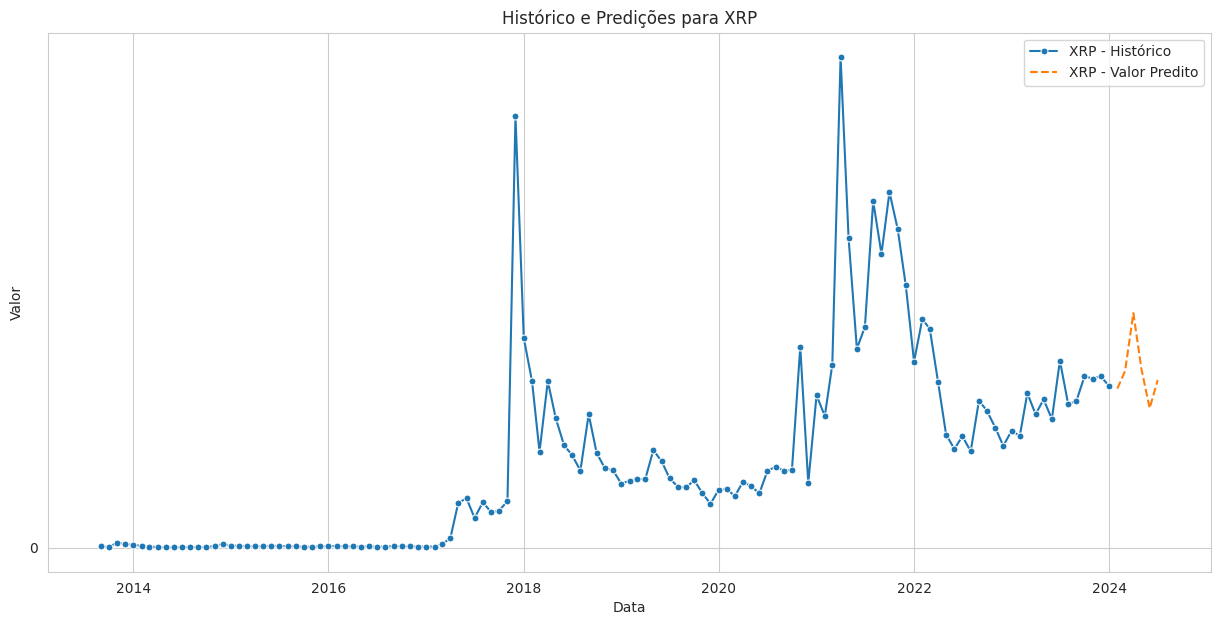

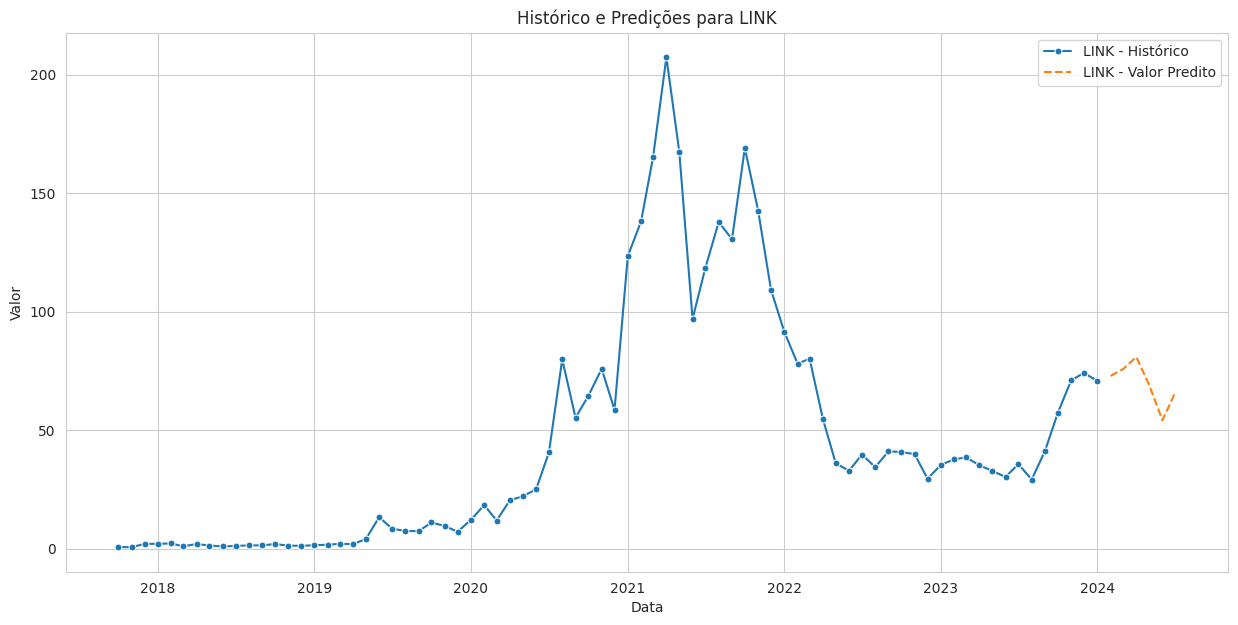

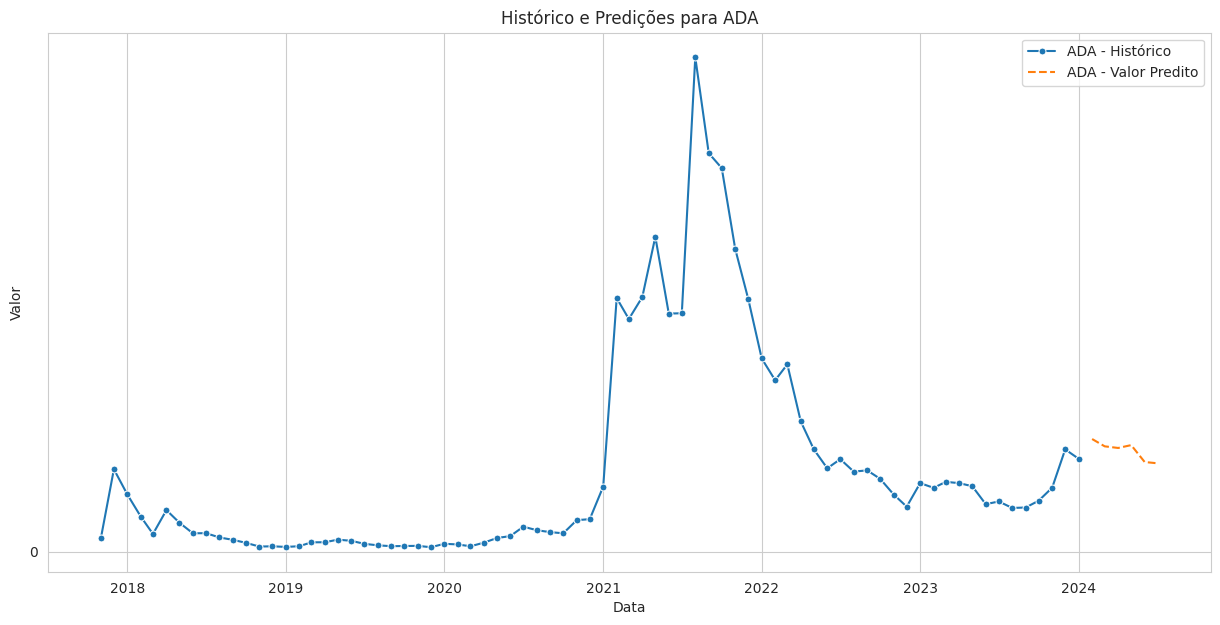

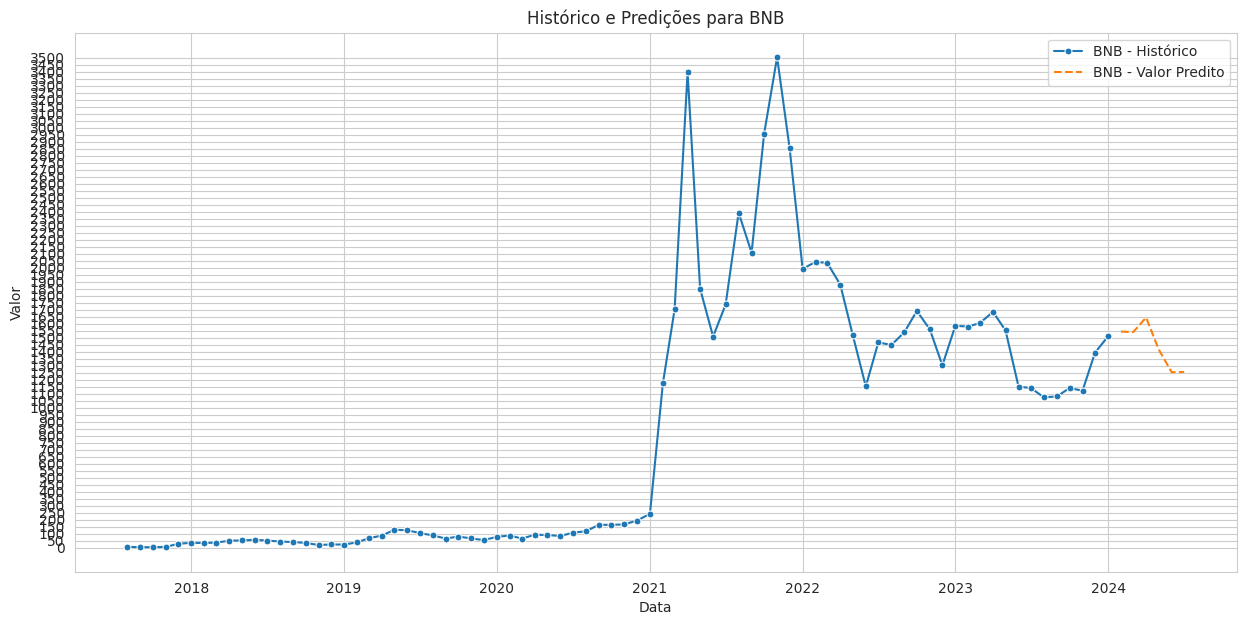

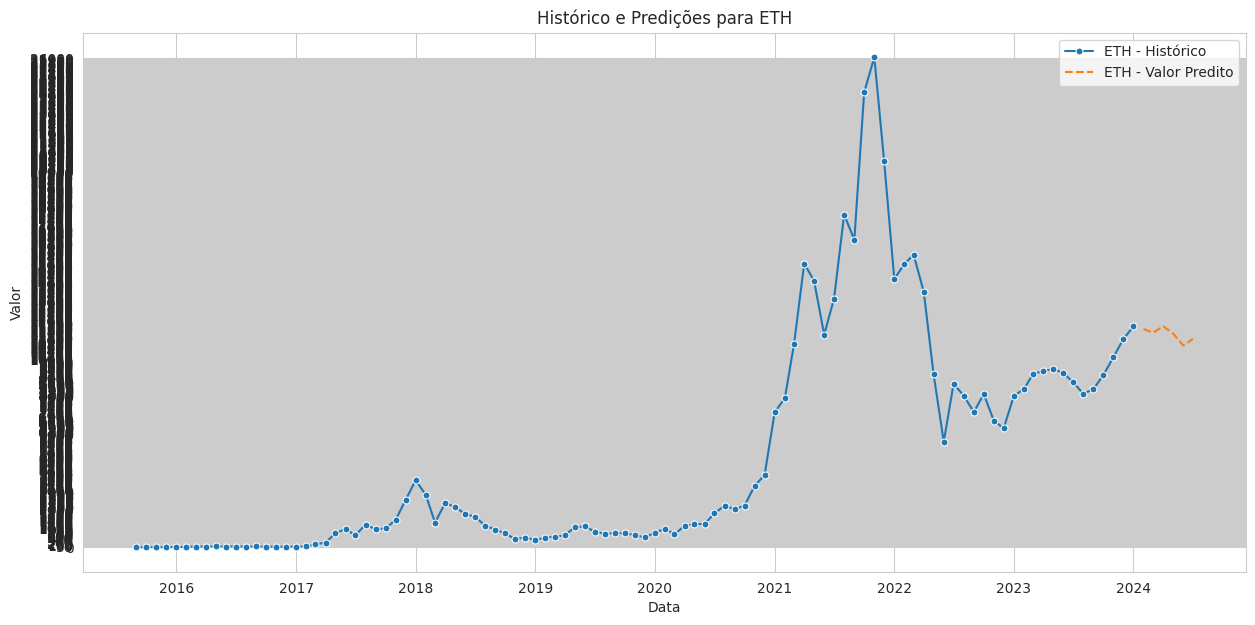

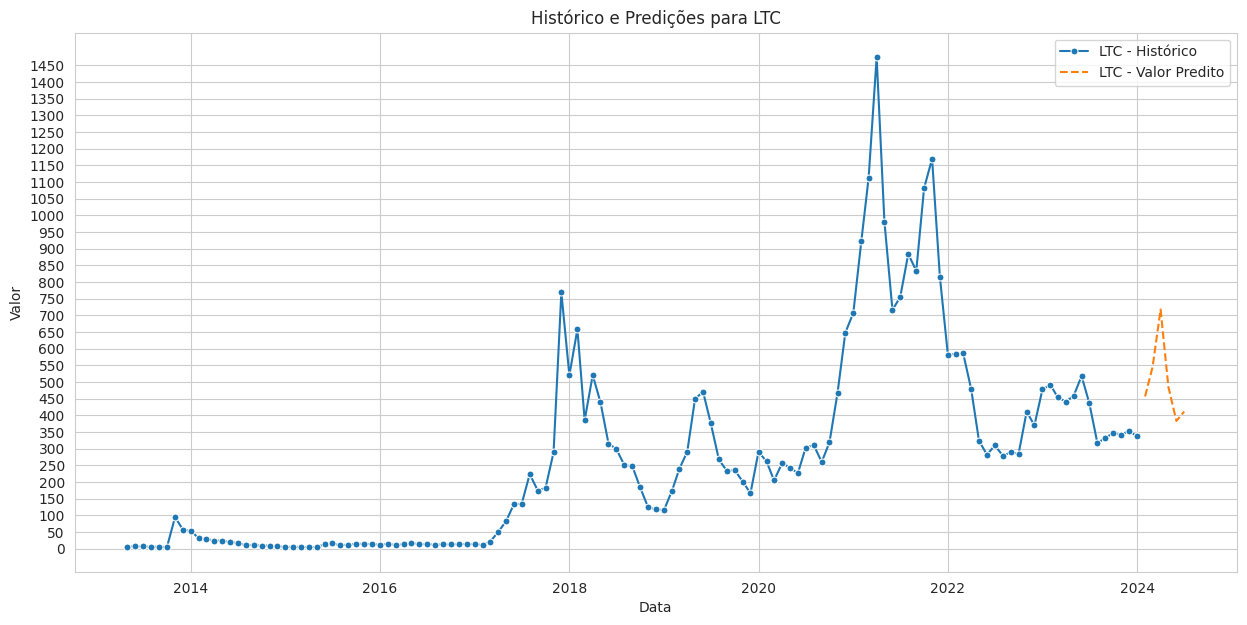

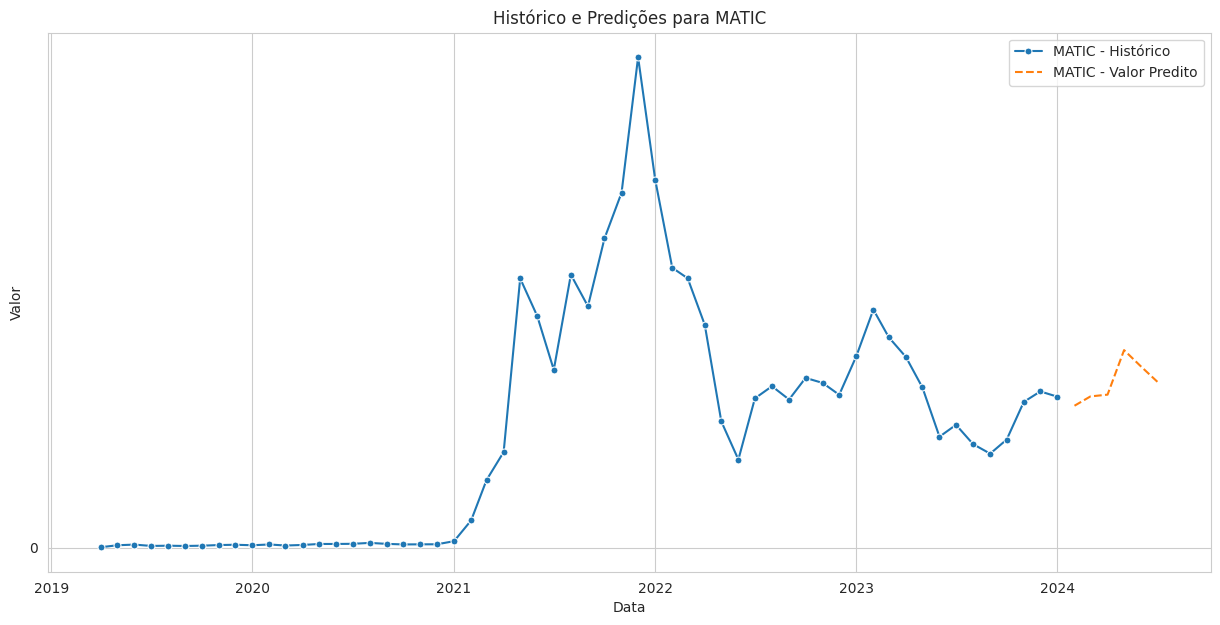

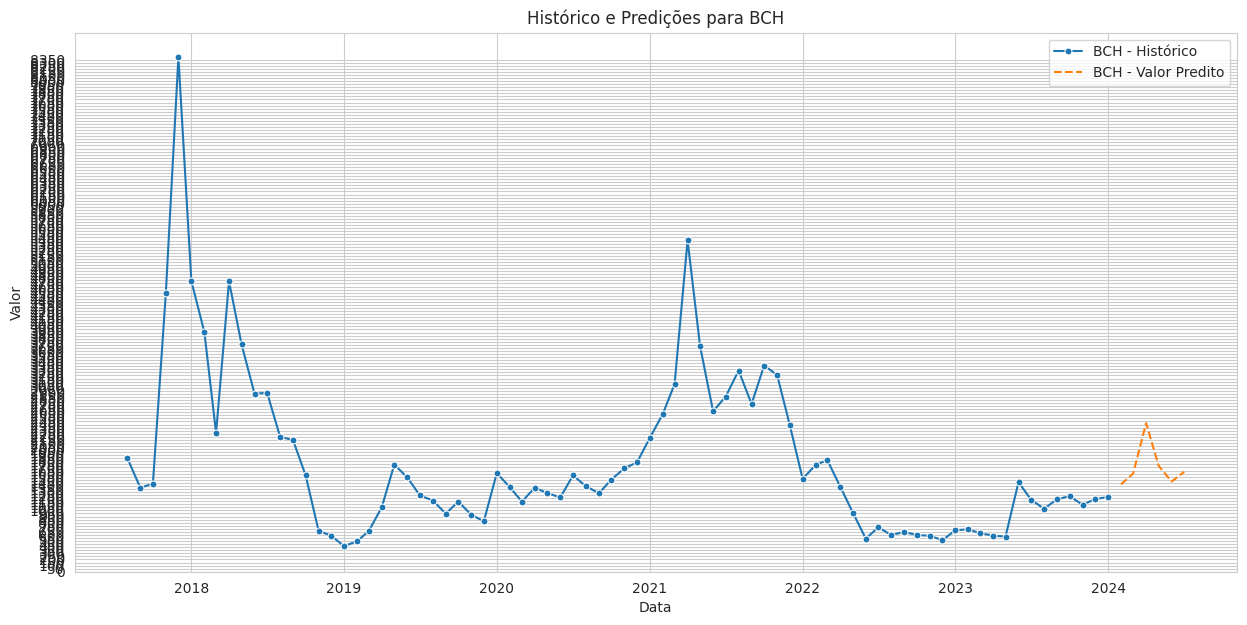

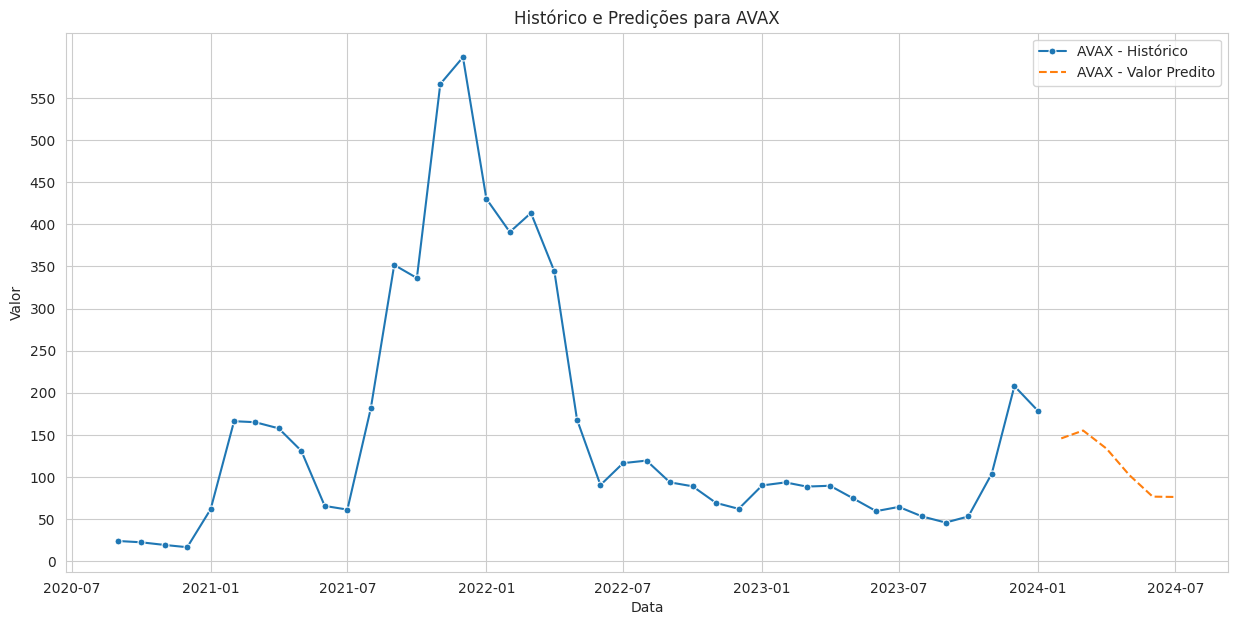

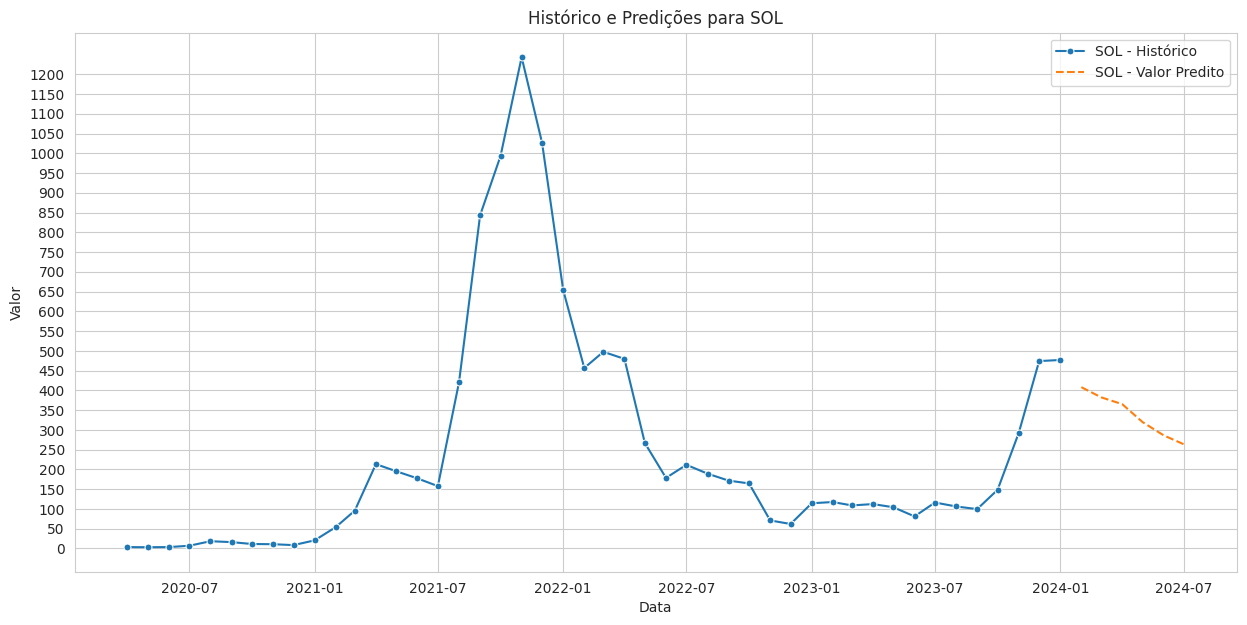

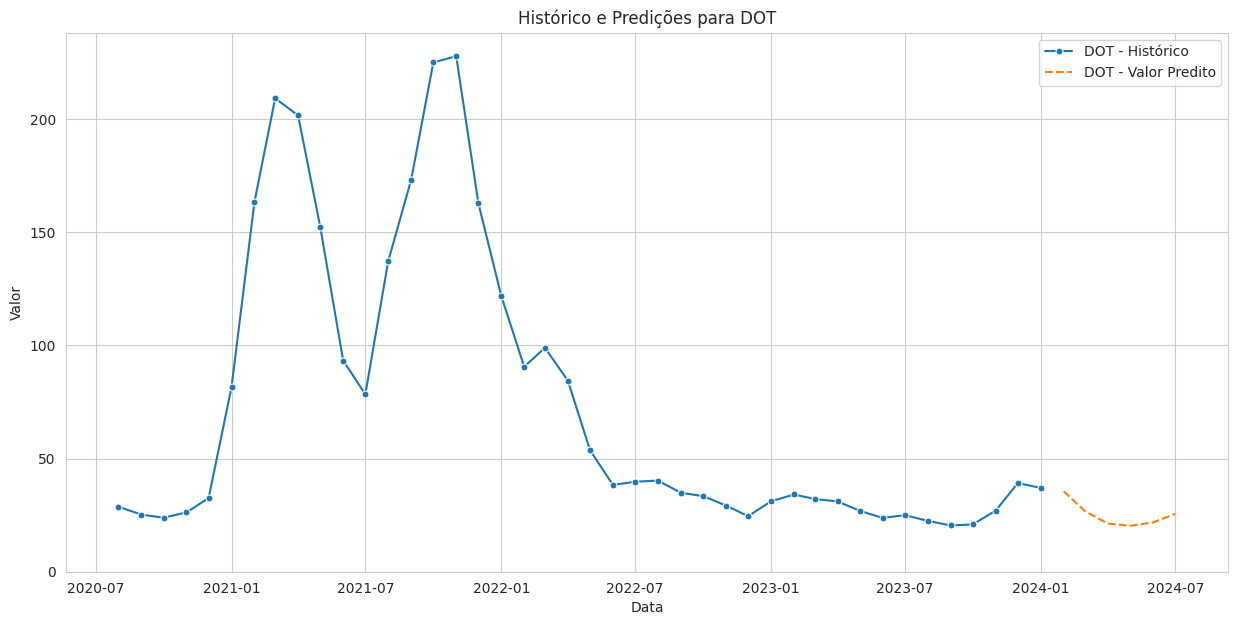

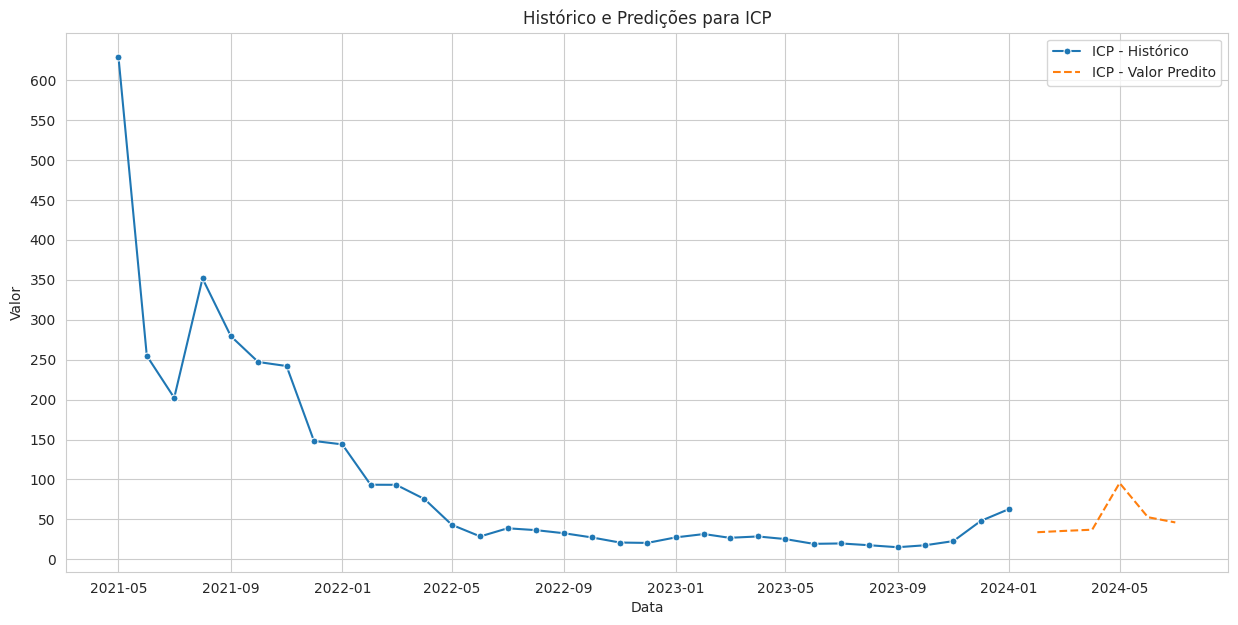

In [97]:
shitcoin_df = df_forecast_results_copy[df_forecast_results_copy["ticker"].isin(shitcoin_list)].copy()
shitcoin_df.index = pd.to_datetime(shitcoin_df.index)
shitcoin_df = shitcoin_df.sort_index()

# Filtre apenas as entradas de PRED
hist_df = shitcoin_df[shitcoin_df['type'] == 'HIST']
predictions_df = shitcoin_df[shitcoin_df['type'] == 'PRED']
insample_df = shitcoin_df[shitcoin_df['type'] == 'IN SAMPLE']

# Loop pelos tickers únicos
for ticker in shitcoin_list:
    # Filtre as entradas para o ticker específico
    ticker_hist_df = hist_df[hist_df['ticker'] == ticker]
    ticker_pred_df = predictions_df[predictions_df['ticker'] == ticker]

    # Crie uma figura para todo o histórico com seaborn
    plt.figure(figsize=(15, 7))

    # Plot histórico com escala ajustada usando seaborn
    sns.lineplot(x=ticker_hist_df.index, y=ticker_hist_df['close_mean'], label=f'{ticker} - Histórico', marker='o', markersize=5)

    # Plot predições com escala ajustada usando seaborn
    sns.lineplot(x=ticker_pred_df.index, y=ticker_pred_df['close_mean'], label=f'{ticker} - Valor Predito', linestyle='--', markersize=5)
#    sns.lineplot(x=insample_df.index, y=insample_df['close_mean'], label=f'{ticker} - Valor Predito (In Sample)', linestyle='--', markersize=5)

    # Aplicar a regra da raiz quadrada para ajustar a escala
    scale_bins = int(np.sqrt(len(hist_df)))  # Número de intervalos
    scale_range = hist_df['close_mean'].max() - hist_df['close_mean'].min()  # Amplitude
    scale_bin_range = scale_range / scale_bins  # Amplitude de cada intervalo (escala)
    plt.yticks(np.arange(0, int(hist_df[hist_df[f"ticker"] == ticker]["close_mean"].max()), 50))

    # Adicione títulos e rótulos
    plt.title(f'Histórico e Predições para {ticker}')
    plt.xlabel('Data')
    plt.ylabel('Valor')
    plt.legend()
    plt.show()

In [ ]:
cols_to_drop = ["best_order", "seasonal_order", "model", "strategy"]
metrics = df_metrics.drop(cols_to_drop, axis=1).merge(df_exometrics.drop(cols_to_drop, axis=1), on=["ticker"] , suffixes=("_sarima", "_sarimax"))
metrics = metrics.merge(df_xmetrics_copy.drop("strategy", axis=1),  on=["ticker"])
metrics.sort_values(by="mape_sarima")[["ticker",	"mape_sarima", "mape_sarimax", "mape_cv", "mae_sarima", "mae_sarimax",		"mae_cv"]]

In [ ]:
# from pmdarima import auto_arima
# from statsmodels.tsa.statespace.sarimax import SARIMAX
# from sklearn.metrics import mean_absolute_error
# from tqdm import tqdm

# def preprocess_data(df, ticker, feature_columns):
#     df_copy = df.fillna(0).copy()
#     df_filtered = df_copy[df_copy[ticker] > 0][[ticker] + feature_columns].copy()
#     return df_filtered

# def train_sarima_model(train_data, ticker, order, seasonal_order, feature_columns=None, exog=None):
#     train_data.index = pd.to_datetime(train_data.index)
#     train_data = train_data.sort_index()

#     if exog is None:
#         model = SARIMAX(train_data[ticker], order=order, seasonal_order=seasonal_order)
#     else:
#         model = SARIMAX(train_data[ticker], exog=train_data[feature_columns], order=order, seasonal_order=seasonal_order)

#     res = model.fit(disp=False)
#     return res

# def forecast_and_evaluate(model, test_data, ticker, feature_columns=None, exog_test=None):
#     forecast_in_sample = model.predict(start=len(model.data.endog), end=len(test_data)-1, exog=exog_test, dynamic=False)
#     actual_values = test_data[ticker].values

#     mape = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100
#     mae = mean_absolute_error(actual_values, forecast_in_sample)

#     return forecast_in_sample, mape, mae

# def store_metrics(metrics_list, ticker, model_type, order, seasonal_order, mape, mae):
#     metrics_dict = {
#         "ticker": ticker,
#         "model": model_type,
#         "best_order": order,
#         "seasonal_order": seasonal_order,
#         "strategy": "HOLD OUT",
#         "mape": mape,
#         "mae": mae
#     }
#     metrics_list.append(metrics_dict)

# # Variáveis comuns para ambos os modelos
# df_uni = df.fillna(0).copy()
# train_size = len(df_uni) - 10

# df_metrics = []
# df_exometrics = []

# for ticker in tqdm(best_params_dict.keys()):
#     # Univariado
#     uni_df = preprocess_data(df, ticker, [])
#     train, test = uni_df[:train_size], uni_df[train_size:]

#     stepwise_fit = auto_arima(train[ticker], **arima_params)
#     order = stepwise_fit.get_params()['order']
#     seasonal_order = stepwise_fit.get_params()['seasonal_order']

#     model = train_sarima_model(train, ticker, order, seasonal_order)
#     exog_test = None  # No exogenous variables for univariate model

#     forecast_in_sample, mape, mae = forecast_and_evaluate(model, test, ticker, exog_test=exog_test)
#     store_metrics(df_metrics, ticker, "SARIMA", order, seasonal_order, mape, mae)

#     # Multivariado
#     multi_df = preprocess_data(df, ticker, feature_columns)
#     train, test = multi_df[:train_size], multi_df[train_size:]

#     stepwise_fit = auto_arima(train[ticker], exogenous=train[feature_columns], seasonal=True, m=12, trace=False)
#     order = stepwise_fit.get_params()['order']
#     seasonal_order = stepwise_fit.get_params()['seasonal_order']

#     model = train_sarima_model(train, ticker, order, seasonal_order, feature_columns=feature_columns, exog=train[feature_columns])
#     exog_test = test[feature_columns]

#     forecast_in_sample, mape, mae = forecast_and_evaluate(model, test, ticker, feature_columns=feature_columns, exog_test=exog_test)
#     store_metrics(df_exometrics, ticker, "SARIMAX", order, seasonal_order, mape, mae)

# # Transformar as listas de métricas em DataFrames
# df_metrics = pd.DataFrame(df_metrics)
# df_exometrics = pd.DataFrame(df_exometrics)

In [ ]:
# from sklearn.metrics import mean_absolute_error

# df_metrics = []
# df_exometrics = []

# for ticker, params in tqdm(best_params_dict.items()):
#     df_uni = df.fillna(0).copy()

#     # Univariado
#     df_uni = df_uni[df_uni[ticker] > 0][[ticker]].copy()

#     train_size = len(df_uni) - 10
#     train, test = df_uni[:train_size], df_uni[train_size:]

#     BEST_ORDER = params["best_order"]
#     BEST_SEASONAL_ORDER = params["best_seasonal_order"]

#     # Certifique-se de que o índice seja do tipo de data
#     train.index = pd.to_datetime(train.index)

#     # Garanta que o índice esteja ordenado de forma crescente
#     train = train.sort_index()

#     # Ajustar o modelo SARIMAX aos dados de treinamento
#     model = SARIMAX(train[ticker], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
#     res = model.fit(disp=False)

#     # Fazer previsões in-sample para o conjunto de teste
#     forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, dynamic=False)

#     # Calculando MAPE
#     actual_values = test[ticker].values
#     mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

#     # Calculando MAE
#     mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

#     # Armazenar métricas em uma lista
#     metrics_dict = {
#         "ticker": ticker,
#         "model": "SARIMA",
#         "best_order": BEST_ORDER,
#         "seasonal_order": BEST_SEASONAL_ORDER,
#         "strategy": "HOLD OUT",
#         "mape": mape_in_sample_sarima,
#         "mae": mae_in_sample_sarima
#     }
#     df_metrics.append(metrics_dict)

#     # Multivariado
#     df_uni = df.fillna(0).copy()

#     # Selecione todas as colunas, exceto a coluna alvo (ticker)
#     feature_columns = [col for col in df_uni.columns if col != ticker]

#     df_uni = df_uni[df_uni[ticker] > 0][[ticker] + feature_columns].copy()

#     train_size = len(df_uni) - 10
#     train, test = df_uni[:train_size], df_uni[train_size:]

#     # Certifique-se de que o índice seja do tipo de data
#     train.index = pd.to_datetime(train.index)

#     # Garanta que o índice esteja ordenado de forma crescente
#     train = train.sort_index()

#     # Ajustar o modelo SARIMAX aos dados de treinamento
#     model = SARIMAX(train[ticker], exog=train[feature_columns], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER)
#     res = model.fit(disp=False)

#     # Fazer previsões in-sample para o conjunto de teste
#     exog_test = test[feature_columns]
#     forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, exog=exog_test, dynamic=False)

#     # Calculando MAPE
#     mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

#     # Calculando MAE
#     mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

#     # Armazenar métricas em uma lista
#     metrics_dict = {
#         "ticker": ticker,
#         "model": "SARIMAX",
#         "best_order": BEST_ORDER,
#         "seasonal_order": BEST_SEASONAL_ORDER,
#         "strategy": "HOLD OUT",
#         "mape": mape_in_sample_sarima,
#         "mae": mae_in_sample_sarima
#     }
#     df_exometrics.append(metrics_dict)

# # Transformar as listas de métricas em DataFrames
# df_metrics = pd.DataFrame(df_metrics)
# df_exometrics = pd.DataFrame(df_exometrics)

In [ ]:
# from pmdarima import auto_arima
# from sklearn.metrics import mean_absolute_error

# df_metrics = []
# df_exometrics = []

# for ticker in tqdm(best_params_dict.keys()):
#     df_uni = df.fillna(0).copy()

#     # Univariado
#     df_uni = df_uni[df_uni[ticker] > 0][[ticker]].copy()

#     train_size = len(df_uni) - 10
#     train, test = df_uni[:train_size], df_uni[train_size:]

#     # Utilizar auto_arima para encontrar os melhores parâmetros
#     stepwise_fit = auto_arima(train[ticker], seasonal=True, m=12, trace=False)
#     BEST_ORDER = stepwise_fit.get_params()['order']
#     BEST_SEASONAL_ORDER = stepwise_fit.get_params()['seasonal_order']

#     # Certifique-se de que o índice seja do tipo de data
#     train.index = pd.to_datetime(train.index)

#     # Garanta que o índice esteja ordenado de forma crescente
#     train = train.sort_index()

#     # Ajustar o modelo SARIMAX aos dados de treinamento
#     model = SARIMAX(train[ticker], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER, trace=False)
#     res = model.fit(disp=False)

#     # Fazer previsões in-sample para o conjunto de teste
#     forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, dynamic=False)

#     # Calculando MAPE
#     actual_values = test[ticker].values
#     mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

#     # Calculando MAE
#     mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

#     # Armazenar métricas em uma lista
#     metrics_dict = {
#         "ticker": ticker,
#         "model": "SARIMA",
#         "best_order": BEST_ORDER,
#         "seasonal_order": BEST_SEASONAL_ORDER,
#         "strategy": "HOLD OUT",
#         "mape": mape_in_sample_sarima,
#         "mae": mae_in_sample_sarima
#     }
#     df_metrics.append(metrics_dict)

#     # Multivariado
#     df_uni = df.fillna(0).copy()

#     # Selecione todas as colunas, exceto a coluna alvo (ticker)
#     feature_columns = [col for col in df_uni.columns if col != ticker]

#     df_uni = df_uni[df_uni[ticker] > 0][[ticker] + feature_columns].copy()

#     train_size = len(df_uni) - 10
#     train, test = df_uni[:train_size], df_uni[train_size:]

#     # Utilizar auto_arima para encontrar os melhores parâmetros
#     stepwise_fit = auto_arima(train[ticker], exogenous=train[feature_columns], seasonal=True, m=12, trace=False)
#     BEST_ORDER = stepwise_fit.get_params()['order']
#     BEST_SEASONAL_ORDER = stepwise_fit.get_params()['seasonal_order']

#     # Certifique-se de que o índice seja do tipo de data
#     train.index = pd.to_datetime(train.index)

#     # Garanta que o índice esteja ordenado de forma crescente
#     train = train.sort_index()

#     # Ajustar o modelo SARIMAX aos dados de treinamento
#     model = SARIMAX(train[ticker], exog=train[feature_columns], order=BEST_ORDER, seasonal_order=BEST_SEASONAL_ORDER, trace=False)
#     res = model.fit(disp=False)

#     # Fazer previsões in-sample para o conjunto de teste
#     exog_test = test[feature_columns]
#     forecast_in_sample = res.predict(start=len(train), end=len(df_uni)-1, exog=exog_test, dynamic=False)

#     # Calculando MAPE
#     mape_in_sample_sarima = np.mean(np.abs((actual_values - forecast_in_sample) / actual_values)) * 100

#     # Calculando MAE
#     mae_in_sample_sarima = mean_absolute_error(test[ticker].values, forecast_in_sample)

#     # Armazenar métricas em uma lista
#     metrics_dict = {
#         "ticker": ticker,
#         "model": "SARIMAX",
#         "best_order": BEST_ORDER,
#         "seasonal_order": BEST_SEASONAL_ORDER,
#         "strategy": "HOLD OUT",
#         "mape": mape_in_sample_sarima,
#         "mae": mae_in_sample_sarima
#     }
#     df_exometrics.append(metrics_dict)

# # Transformar as listas de métricas em DataFrames
# df_metrics = pd.DataFrame(df_metrics)
# df_exometrics = pd.DataFrame(df_exometrics)

# PLOT

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_plot = pd.read_parquet("../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/df_forecast_results.parquet")
df_plot

In [ ]:
!pip install -U gradio --quiet

In [ ]:
# Carregar o DataFrame fornecido
# Substitua 'caminho/do/arquivo.csv' pelo caminho real do seu arquivo CSV ou carregue os dados de outra maneira.
#df_plot = pd.read_csv('caminho/do/arquivo.csv', parse_dates=['timestamp'])

import gradio as gr

# Função para plotar o gráfico com base nos parâmetros fornecidos
def plot_graph(ticker, start_date):
    filtered_df = df_plot[(df_plot['ticker'] == ticker) & (df_plot['timestamp'] >= start_date)]

    fig = px.line(filtered_df, x='timestamp', y='close_mean', title=f'{ticker} Close Mean Over Time')
    fig.update_layout(xaxis_title='Date', yaxis_title='Close Mean')

    return fig

# Definir as opções para a caixa de seleção
ticker_options = list(df_plot['ticker'].unique())

# Criar a interface Gradio
iface = gr.Interface(fn=plot_graph,
                     inputs=[
                         gr.SelectBox(choices=ticker_options, label='Select Ticker'),
                         gr.DatePicker(label='Select Start Date', default='2018-01-01')
                     ],
                     outputs=gr.Plot(type='plotly'))

# Lançar a interface
iface.launch()

In [ ]:
df_plot #.head() #[df_plot.index == "2023-02-01"]

In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]

# Criar o gráfico
fig = px.line()

# Iterar sobre os tickers
for ticker in tk:
    # Filtrar dados para o ticker atual
    df_ticker = df_plot_subplot[df_plot_subplot["ticker"] == ticker]

    # Adicionar linha para HIST
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "HIST"].index,
                    y=df_ticker[df_ticker["type"] == "HIST"]["close_mean"],
                    mode='lines', name=f'{ticker}', )

    # Adicionar linha para PRED (tracejada)
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "PRED"].index,
                    y=df_ticker[df_ticker["type"] == "PRED"]["close_mean"],
                    mode='lines', name=f'{ticker}', line=dict(dash='dash'))

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
)

# Exibir o gráfico
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]

# Filtrar os dados para HIST e PRED
df_hist = df_plot_subplot[df_plot_subplot["type"] == "HIST"]
df_pred = df_plot_subplot[df_plot_subplot["type"] == "PRED"]

# Criar o gráfico
fig = px.line()

# Adicionar as linhas para HIST
df_ticker_hist = df_hist[df_hist["ticker"] == ticker]
fig.add_scatter(x=df_ticker_hist.index, y=df_ticker_hist["close_mean"], mode='lines', name=f'{ticker}') #, line=dict(color='blue'))

# Adicionar as linhas para PRED (tracejadas)
df_ticker_pred = df_pred[df_pred["ticker"] == ticker]
fig.add_scatter(x=df_ticker_pred.index, y=df_ticker_pred["close_mean"], mode='lines', line=dict(dash='dash'), name=f'{ticker}')

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
)

# Exibir o gráfico
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]

# Filtrar os dados para HIST e PRED
df_hist = df_plot_subplot[df_plot_subplot["type"] == "HIST"]
df_pred = df_plot_subplot[df_plot_subplot["type"] == "PRED"]

# Criar o gráfico
fig = px.line()

# Adicionar as linhas para HIST
for ticker in tk:
    df_ticker_hist = df_hist[df_hist["ticker"] == ticker]
    fig.add_scatter(x=df_ticker_hist.index, y=df_ticker_hist["close_mean"],
                    mode='lines') #, name=f'{ticker}') #, line=dict(color='blue'))

# Adicionar as linhas para PRED (tracejadas)
for ticker in tk:
    df_ticker_pred = df_pred[df_pred["ticker"] == ticker]
    fig.add_scatter(x=df_ticker_pred.index, y=df_ticker_pred["close_mean"],
                    mode='lines', line=dict(dash='dash')) #name=f'{ticker}', line=dict(dash='dash'))

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
)

# Exibir o gráfico
fig.show()

In [ ]:
#tk = ["XRP", "DOGE"]
tk = [#'BTC',
      'LTC', 'XRP', 'DOGE', 'USDT', #'ETH',
      'BCH', 'BNB', 'LINK',
       'TRX', 'ADA', 'USDC', 'MATIC', 'DAI', 'SOL', 'DOT', 'SHIB', 'AVAX',
       'ICP', 'TON']
df_plot_subplot = df_plot[(df_plot["ticker"].isin(tk)) & (df_plot.index > "2018-01-01")]
# plx.line(df_plot_subplot, y="close_mean", color="ticker", hover_data="type", hover_name="type")

# # Atualize a formatação dos eixos x e y
# fig.update_layout(
#     xaxis_tickformat="%d/%m/%Y",  # Formato desejado para o eixo x (data)
#     yaxis_tickformat=",.2f"        # Formato desejado para o eixo y (números)
# )


# Seu código para criar o DataFrame df_plot_subplot...

# Crie o gráfico utilizando o Plotly Express
fig = px.line(df_plot_subplot, y="close_mean", color="ticker", hover_name="ticker", hover_data=["type", "model"])

# Atualize a formatação dos eixos x e y
fig.update_layout(
#    xaxis_tickformat="%d/%m/%Y",  # Formato desejado para o eixo x (data)
    yaxis_tickformat=",.2f"        # Formato desejado para o eixo y (números)
)

# Exiba o gráfico
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
# df_plot_subplot = ...

# Criar o gráfico
fig = px.line()

# Iterar sobre os tickers
for ticker in tk:
    # Filtrar dados para o ticker atual
    df_ticker = df_plot_subplot[df_plot_subplot["ticker"] == ticker]

    # Adicionar linha para HIST
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "HIST"].index,
                    y=df_ticker[df_ticker["type"] == "HIST"]["close_mean"],
                    mode='lines', name=f'{ticker}', line=dict(color='blue'))

    # Adicionar linha para PRED (tracejada)
    fig.add_scatter(x=df_ticker[df_ticker["type"] == "PRED"].index,
                    y=df_ticker[df_ticker["type"] == "PRED"]["close_mean"],
                    mode='lines', name=f'{ticker}', line=dict(color='red', dash='dash'))

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
    # Adicionar estilo para as linhas PRED (tracejadas)
    legend=dict(traceorder='reversed'),
)

# Exibir o gráfico
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd

# Seu DataFrame
# df_plot_subplot = ...

# Criar o gráfico
fig = px.line()

# Iterar sobre os tickers
for ticker in tk:
    # Filtrar dados para o ticker atual
    df_ticker = df_plot_subplot[df_plot_subplot["ticker"] == ticker]

    # Adicionar linha para HIST e PRED
    fig.add_scatter(x=df_ticker.index,
                    y=df_ticker["close_mean"],
                    mode='lines',
                    name=f'{ticker}',
                    line=dict(dash='solid'),  # Linha HIST
                    legendgroup=f'{ticker}')

    fig.add_scatter(x=df_ticker[df_ticker["type"] == "PRED"].index,
                    y=df_ticker[df_ticker["type"] == "PRED"]["close_mean"],
                    mode='lines',
                    name=f'{ticker}',
                    line=dict(dash='dash'),  # Linha PRED
                    legendgroup=f'{ticker}')

# Adicionar rótulos e título
fig.update_layout(
    title="Histórico e Previsão para os Tickers",
    xaxis_title="Data",
    yaxis_title="Valor",
    legend=dict(traceorder='reversed'),
)

# Exibir o gráfico
fig.show()


In [ ]:
df_plot_subplot[df_plot_subplot["ticker"] == "ETH"].index.min(), df_plot_subplot[df_plot_subplot["ticker"] == "ETH"].index.max(), df_plot_subplot[df_plot_subplot["ticker"] == "BTC"].index.min(), df_plot_subplot[df_plot_subplot["ticker"] == "BTC"].index.max()

In [ ]:
import pandas as pd
import os

def salvar_dados(df, df_month_mean, df_month_mean_pivot, silver_path, gold_path):
    """
    Salva DataFrames em formatos específicos nos diretórios 'silver' e 'gold'.

    Parameters:
    - df (pd.DataFrame): O DataFrame principal a ser salvo em 'silver'.
    - df_month_mean (pd.DataFrame): O DataFrame a ser salvo em 'silver'.
    - df_month_mean_pivot (pd.DataFrame): O DataFrame a ser salvo em 'gold'.
    - silver_path (str): O caminho para o diretório 'silver'.
    - gold_path (str): O caminho para o diretório 'gold'.

    Returns:
    - None

    Example:
    >>> salvar_dados(df, df_month_mean, df_month_mean_pivot, "../crypto_forecast/silver/", "../crypto_forecast/gold/")
    """
    # Criar diretórios 'silver' e 'gold' se não existirem
    os.makedirs(silver_path, exist_ok=True)
    os.makedirs(gold_path, exist_ok=True)

    # Salvando no diretório 'silver'
    silver_filename = "df_silver.parquet"
    silver_save_path = os.path.join(silver_path, silver_filename)
    df.to_parquet(silver_save_path)

    df_month_mean_filename = "df_month_mean.parquet"
    df_month_mean_save_path = os.path.join(silver_path, df_month_mean_filename)
    df_month_mean.to_parquet(df_month_mean_save_path)

    # Salvando no diretório 'gold'
    gold_filename = "df_gold.parquet"
    gold_save_path = os.path.join(gold_path, gold_filename)
    df_month_mean_pivot.to_parquet(gold_save_path)

    df_forecast_results_name = "df_forecast_results.parquet"
    gold_save_path = os.path.join(gold_path, df_forecast_results_name)
    df_forecast_results.to_parquet(gold_save_path)

# exemplo
# silver_path = glob.glob('../silver/')
# gold_path = glob.glob('../gold/')

silver_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/silver/"
gold_path = "../content/drive/MyDrive/01 - Projetos/crypto_forecast/gold/"

salvar_dados(df, df_month_mean, df_month_mean_pivot, df_forecast_results, silver_path, gold_path)

In [ ]:
# TO-DO
## PREVISAO COM BAGGING/BOSSTING
## GERAÇÃO DE DADOS SINTÉTICOS
## PREVISÃO
## ARMAENAMENTO